# **De Zéro à 2048 : Construire un environnement RL avec JAX**

<img src="https://www.freecodecamp.org/news/content/images/2021/08/giphy.gif" width="50%" />

<a href="https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2024/blob/main/practicals/RL_2048/From_Zero_to_2048_Building_RL_environment_with_JAX_(Intermediate_Level)_French.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> 

© Deep Learning Indaba 2024. Licence Apache 2.0.

**Auteurs :** Omayma Mahjoub, Siddarth Singh, Wiem Khlifi, Jawhar Afli, et Ruan de Kock.

**Traducteurs :** Omayma Mahjoub et Ismael Kone.

**Introduction :**

Dans ce pratique, nous explorerons la création d'un environnement JAX pour le jeu "2048". En Apprentissage par Renforcement (RL), les rôles d'un Agent et d'un Environnement sont cruciaux, car l'environnement est essentiel pour tester et entraîner les algorithmes de RL. D'un autre côté, JAX est devenu un outil clé dans l'avancement de l'implémentation des algorithmes de RL, permettant des architectures plus efficaces et la création de systèmes distribués qui peuvent être entraînés en quelques minutes sur des machines locales avec GPU. Cependant, pour atteindre cette efficacité, l'environnement doit être "jaxifié". L'importance d'adapter les environnements pour JAX est soulignée par l'accent croissant mis sur les dépôts d'environnements jaxifiés comme Jumanji, Gymnax, et JaxMARL.

Au cours de ce pratique, vous serez initié aux fondamentaux des environnements JAX, en vous concentrant sur la conception sans état "stateless" et avec état "stateful". Nous utiliserons le jeu 2048 comme exemple pour construire un environnement, en définissant des composants clés tels que les récompenses, les observations et les états. Vous apprendrez également la structure de base d'un environnement et des termes connexes tels que "reset", "step" et "timestep".

L'objectif n'est pas seulement de créer cet environnement en utilisant JAX, mais aussi de comprendre les avantages d'utiliser JAX pour l'implémentation d'environnements, en particulier en termes de performance et d'évolutivité. À la fin de ce pratique, vous aurez acquis des compétences fondamentales dans la conception et l'implémentation d'environnements basés sur JAX, fournissant une solide porte d'entrée vers la programmation avancée d'environnements RL avec JAX.

**Sujets :**

Contenu : Apprentissage par Renforcement

Niveau :  <font color='orange'>`Intermédiaire`</font>


**Prérequis :**

* Une certaine familiarité avec Numpy et [JAX](https://github.com/google/jax).
* Bases des réseaux de neurones.
* Bases du RL.

**Avant de commencer :**

Pour ce pratique, si vous utilisez Colab, vous aurez besoin d'utiliser un GPU pour accélérer l'entraînement. Pour ce faire, allez dans le menu "Runtime" dans Colab, sélectionnez "Change runtime type", puis dans le menu contextuel, choisissez "GPU" dans la boîte "Hardware accelerator".


# Installation et Imports


In [ ]:
## Installer et importer tout ce qui est requis. Capture cache la sortie de la cellule.
# @title Configuration (Exécutez cette cellule en premier)
%%capture

# installer le code d'entraînement jumanji pour le rendu
!pip install --quiet -U "jumanji[train] @ git+https://github.com/instadeepai/jumanji.git@main"

import io
import os
import pickle
import warnings

import imageio
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import requests
from huggingface_hub import hf_hub_download
from hydra import compose, initialize
from IPython.display import Image, display, clear_output
from jumanji import specs
from jumanji.training.setup_train import setup_agent, setup_env
from jumanji.training.utils import first_from_device
from jumanji.types import TimeStep, restart, termination, transition, StepType
from jumanji.environments.logic.game_2048.viewer import Game2048Viewer
from jumanji.viewer import Viewer
from jumanji.env import Environment
from tqdm import notebook
import random
import pygame
from pygame.locals import *
from chex import Array, Numeric, PRNGKey
from typing_extensions import TypeAlias
# "State" et "Observation" sont implémentés en tant que NamedTuple.
from typing import NamedTuple, Tuple, Optional, Sequence


# supprimer tous les avertissements
warnings.filterwarnings("ignore")

%matplotlib notebook

def download_file(url: str, file_path: str) -> None:
    # Envoyer une requête HTTP GET à l'URL
    response = requests.get(url)
    # Vérifier si la requête a réussi (code de statut 200)
    if response.status_code == 200:
        with open(file_path, "wb") as f:
            f.write(response.content)
    else:
        print("Échec du téléchargement du fichier.")


def download_jumanji_agent(
    env_name: str, model_checkpoint_dir: str = "trained_policy_checkpoint"
):
    os.makedirs("configs", exist_ok=True)
    config_url = "https://raw.githubusercontent.com/instadeepai/jumanji/main/jumanji/training/configs/config.yaml"
    download_file(config_url, "configs/config.yaml")
    env_url = f"https://raw.githubusercontent.com/instadeepai/jumanji/main/jumanji/training/configs/env/{env_name}.yaml"
    os.makedirs("configs/env", exist_ok=True)
    download_file(env_url, f"configs/env/{env_name}.yaml")
    with initialize(version_base=None, config_path="configs"):
        cfg = compose(
            config_name="config.yaml", overrides=[f"env={env_name}", f"agent=a2c"]
        )
    # Choisir le checkpoint correspondant depuis l'InstaDeep Model Hub
    # https://huggingface.co/InstaDeepAI
    REPO_ID = f"InstaDeepAI/jumanji-benchmark-a2c-{cfg.env.registered_version}"
    FILENAME = f"{cfg.env.registered_version}_training_state"
    model_checkpoint = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)

    # Charger les données du checkpoint
    with open(model_checkpoint, "rb") as f:
        training_state = pickle.load(f)

    # Enregistrer l'état d'entraînement chargé
    with open(model_checkpoint_dir, "wb") as f:
        pickle.dump(training_state, f)


# Nous exécutons également le code qui récupérera l'agent jumanji et configurera les configurations
download_jumanji_agent(env_name="game_2048")


In [ ]:
# @title Fonctions Utiles (Exécutez cette cellule avant de commencer le pratique)

def rollout_and_render_policy(
    env_name: str,
    agent_name: str,
    model_checkpoint_dir: str = "trained_policy_checkpoint",
):
    with open(model_checkpoint_dir, "rb") as f:
        training_state = pickle.load(f)

    with initialize(version_base=None, config_path="configs"):
        cfg = compose(
            config_name="config.yaml",
            overrides=[f"env={env_name}", f"agent={agent_name}"],
        )

    params = first_from_device(training_state.params_state.params)
    env = setup_env(cfg).unwrapped
    agent = setup_agent(cfg, env)
    if agent_name == "a2c":
        policy = jax.jit(agent.make_policy(params.actor, stochastic=False))
    else:
        # pas besoin de paramètres pour un agent aléatoire
        policy = jax.jit(agent.make_policy(None, stochastic=False))

    NUM_EPISODES = 2

    reset_fn = jax.jit(env.reset)
    step_fn = jax.jit(env.step)
    states = []
    key = jax.random.PRNGKey(cfg.seed)
    for episode in range(NUM_EPISODES):
        key, reset_key = jax.random.split(key)
        state, timestep = reset_fn(reset_key)
        states.append(state)
        while not timestep.last():
            key, action_key = jax.random.split(key)
            observation = jax.tree_util.tree_map(
                lambda x: x[None], timestep.observation
            )
            if agent_name == "a2c":
                action, _ = policy(observation, action_key)
            else:
                action = policy(observation, action_key)
            state, timestep = step_fn(state, action.squeeze(axis=0))
            states.append(state)
        # Geler le cadre terminal pour faire une pause dans le GIF.
        for _ in range(3):
            states.append(state)

    # Générer et stocker un gif de la politique
    gif_path = f"animation_{env_name}_{agent_name}.gif"
    env.animate(states, interval=150, save_path=gif_path)

    # Afficher le GIF généré
    display(Image(filename=gif_path))


# 0. Aperçu de l'Apprentissage par Renforcement


>**🤖 L'Apprentissage par Renforcement (RL)** est une branche de l'Apprentissage Automatique (ML) qui se concentre sur l'apprentissage des actions optimales dans des scénarios spécifiques par le biais d'interactions plutôt que d'utiliser des exemples étiquetés. Contrairement à l'apprentissage supervisé, le RL ne repose pas sur des étiquettes prédéfinies mais plutôt sur <font color='green'>"*l'apprentissage des conséquences des actions*"</font> prises dans un environnement.

**Pourquoi apprendre sans données étiquetées ?**

* **💰 Coût et Faisabilité :** La création de jeux de données étiquetés nécessite l'intervention d'experts, ce qui peut être coûteux et complexe, notamment dans des domaines comme la robotique.
* **📉 Limitation de l'Imitation :** Les modèles entraînés sur des données étiquetées ne peuvent qu'imiter les exemples fournis et ne peuvent pas dépasser la performance de l'expert qui a créé le jeu de données.


## 0.1 Différences entre les tâches d'Apprentissage par Renforcement (RL) et d'Apprentissage Supervisé (SL)


* **🔄 Décisions Séquentielles :** Contrairement aux tâches d'Apprentissage Supervisé (SL), où les décisions sont souvent prises en une seule fois (par exemple, classer une image), le RL nécessite de prendre des décisions continues et séquentielles pour contrôler efficacement la raquette.

  > Notez que parfois, le traitement du langage naturel (NLP) ou les tâches de prédiction de séries temporelles sont séquentiels, par exemple en utilisant des [modèles autorégressifs](https://fr.wikipedia.org/wiki/Mod%C3%A8le_autor%C3%A9gressif) comme [GPT](https://arxiv.org/abs/2005.14165) pour prédire le prochain token. Dans ce scénario, la principale différence est l'absence de jeu de données d'entraînement en RL et la manière dont ces systèmes apprennent.

* **📊 Données d'Entraînement :** En RL, vous n'avez généralement pas de jeu de données d'entraînement de comportement expert (une exception à cela est le [RL Hors-Ligne](https://huggingface.co/learn/deep-rl-course/unitbonus3/offline-online)), mais plutôt un environnement avec un système de récompense qui définit ce qui est bon ou mauvais. En SL, vous disposez d'un jeu de données étiqueté avec le comportement désiré.

* **🧠 Processus d'Apprentissage :** L'agent RL s'améliore par essai-erreur, apprenant des résultats de chaque partie pour affiner ses actions au fil du temps.
* **🏆 Objectifs :** L'agent RL vise à maximiser la récompense totale (par exemple, gagner la partie) en apprenant les mouvements optimaux de la raquette, tandis qu'un modèle SL viserait généralement à classer ou prédire sur la base de données statiques.


## 0.2 Devenez votre propre agent RL !

Expérimentons l'apprentissage par renforcement du point de vue de l'agent !

Vous allez jouer le rôle d'un agent qui essaie d'apprendre à résoudre une tâche.
* Vous allez prendre des <font color='blue'>actions</font> en utilisant votre clavier -- vous pouvez aller vers le haut, la gauche, le bas ou la droite en entrant "w", "a", "s" ou "d" (pour les propriétaires de claviers QWERTY) et "z", "q", "s" ou "d" (pour les propriétaires de claviers AZERTY).
* Vous verrez ensuite comment le jeu évolue en regardant la nouvelle <font color='orange'>observation</font> fournie par la carte.
* Vous recevrez également une <font color='green'>récompense</font> pour chaque étape vous indiquant à quel point votre décision précédente était bonne.

Ça a l'air intéressant ? Allons-y ! 🚀


In [ ]:
# @title Exécutez pour démarrer le jeu (clavier QWERTY) !

# Initialiser Pygame avec un affichage fictif
os.environ["SDL_VIDEODRIVER"] = "dummy"  # Empêche l'ouverture de la fenêtre Pygame
pygame.init()

# Définir les constantes
GRID_SIZE = 4
TILE_SIZE = 100
TILE_MARGIN = 10
WINDOW_SIZE = GRID_SIZE * (TILE_SIZE + TILE_MARGIN) + TILE_MARGIN

# Définir les couleurs
BACKGROUND_COLOR = (187, 173, 160)
EMPTY_TILE_COLOR = (205, 193, 180)
TILE_COLORS = {
    2: (238, 228, 218),
    4: (237, 224, 200),
    8: (242, 177, 121),
    16: (245, 149, 99),
    32: (246, 124, 95),
    64: (246, 94, 59),
    128: (237, 207, 114),
    256: (237, 204, 97),
    512: (237, 200, 80),
    1024: (237, 197, 63),
    2048: (237, 194, 46),
}

# Initialiser la police Pygame
pygame.font.init()
FONT = pygame.font.Font(None, 72)
SMALL_FONT = pygame.font.Font(None, 36)

def draw_tile(screen, value, x, y):
    rect = pygame.Rect(x, y, TILE_SIZE, TILE_SIZE)
    pygame.draw.rect(screen, TILE_COLORS.get(value, EMPTY_TILE_COLOR), rect)
    if value:
        text = FONT.render(str(value), True, (119, 110, 101))
        text_rect = text.get_rect(center=(x + TILE_SIZE / 2, y + TILE_SIZE / 2))
        screen.blit(text, text_rect)

def draw_board(board, score):
    screen = pygame.Surface((WINDOW_SIZE, WINDOW_SIZE))
    screen.fill(BACKGROUND_COLOR)
    for row in range(GRID_SIZE):
        for col in range(GRID_SIZE):
            x = col * (TILE_SIZE + TILE_MARGIN) + TILE_MARGIN
            y = row * (TILE_SIZE + TILE_MARGIN) + TILE_MARGIN
            draw_tile(screen, board[row][col], x, y)

    # Dessiner le score
    score_text = SMALL_FONT.render(f"Score : {score}", True, (0, 0, 0))
    screen.blit(score_text, (10, 10))

    # Enregistrer la surface en tant qu'image et l'afficher
    pygame.image.save(screen, "2048_board.png")
    clear_output(wait=True)
    display(Image("2048_board.png"))

def add_new_tile(board):
    empty_cells = list(zip(*np.where(board == 0)))
    if empty_cells:
        cell = random.choice(empty_cells)
        board[cell] = 4 if random.random() > 0.9 else 2
    return board

def merge_left(board):
    new_board = np.zeros((4, 4), dtype=int)
    score = 0
    for i in range(4):
        row = board[i, :]
        new_row = row[row != 0]
        new_row = np.pad(new_row, (0, 4 - len(new_row)), 'constant')
        for j in range(3):
            if new_row[j] == new_row[j + 1]:
                new_row[j] *= 2
                score += new_row[j]  # Ajouter au score
                new_row[j + 1:] = np.roll(new_row[j + 1:], -1)
                new_row[-1] = 0
        new_board[i, :] = new_row
    return new_board, score

def merge_right(board):
    board = np.fliplr(board)
    board, score = merge_left(board)
    board = np.fliplr(board)
    return board, score

def merge_up(board):
    board = board.T
    board, score = merge_left(board)
    board = board.T
    return board, score

def merge_down(board):
    board = board.T
    board, score = merge_right(board)
    board = board.T
    return board, score

def check_game_over(board):
    if np.any(board == 2048):
        return True, "Vous avez gagné !"
    if np.any(board == 0):
        return False, ""
    for direction in [merge_left, merge_right, merge_up, merge_down]:
        if not np.array_equal(board, direction(board.copy())[0]):
            return False, ""
    return True, "Fin de partie !"

def play_game():
    board = np.zeros((4, 4), dtype=int)
    board = add_new_tile(board)
    board = add_new_tile(board)
    score = 0
    draw_board(board, score)

    while True:
        move = input("Entrez un mouvement (w/a/s/d) ou q pour quitter : \n").strip().lower()
        if move == "q":
            break
        if move not in ['w', 'a', 's', 'd']:
            print("Mouvement invalide ! Utilisez w (haut), a (gauche), s (bas), d (droite).")
            continue

        if move == 'w':
            new_board, move_score = merge_up(board.copy())
        elif move == 'a':
            new_board, move_score = merge_left(board.copy())
        elif move == 's':
            new_board, move_score = merge_down(board.copy())
        elif move == 'd':
            new_board, move_score = merge_right(board.copy())

        if np.array_equal(board, new_board):
            print("Mouvement non valide !")
            continue

        score += move_score
        board = add_new_tile(new_board)
        draw_board(board, score)

        game_over, message = check_game_over(board)
        if game_over:
            print(message)
            break

play_game()


In [ ]:
# @title Exécutez pour démarrer le jeu (clavier AZERTY) !

# Initialiser Pygame avec un affichage fictif
os.environ["SDL_VIDEODRIVER"] = "dummy"  # Empêche l'ouverture de la fenêtre Pygame
pygame.init()

# Définir les constantes
GRID_SIZE = 4
TILE_SIZE = 100
TILE_MARGIN = 10
WINDOW_SIZE = GRID_SIZE * (TILE_SIZE + TILE_MARGIN) + TILE_MARGIN

# Définir les couleurs
BACKGROUND_COLOR = (187, 173, 160)
EMPTY_TILE_COLOR = (205, 193, 180)
TILE_COLORS = {
    2: (238, 228, 218),
    4: (237, 224, 200),
    8: (242, 177, 121),
    16: (245, 149, 99),
    32: (246, 124, 95),
    64: (246, 94, 59),
    128: (237, 207, 114),
    256: (237, 204, 97),
    512: (237, 200, 80),
    1024: (237, 197, 63),
    2048: (237, 194, 46),
}

# Initialiser la police Pygame
pygame.font.init()
FONT = pygame.font.Font(None, 72)
SMALL_FONT = pygame.font.Font(None, 36)

def draw_tile(screen, value, x, y):
    rect = pygame.Rect(x, y, TILE_SIZE, TILE_SIZE)
    pygame.draw.rect(screen, TILE_COLORS.get(value, EMPTY_TILE_COLOR), rect)
    if value:
        text = FONT.render(str(value), True, (119, 110, 101))
        text_rect = text.get_rect(center=(x + TILE_SIZE / 2, y + TILE_SIZE / 2))
        screen.blit(text, text_rect)

def draw_board(board, score):
    screen = pygame.Surface((WINDOW_SIZE, WINDOW_SIZE))
    screen.fill(BACKGROUND_COLOR)
    for row in range(GRID_SIZE):
        for col in range(GRID_SIZE):
            x = col * (TILE_SIZE + TILE_MARGIN) + TILE_MARGIN
            y = row * (TILE_SIZE + TILE_MARGIN) + TILE_MARGIN
            draw_tile(screen, board[row][col], x, y)

    # Dessiner le score
    score_text = SMALL_FONT.render(f"Score : {score}", True, (0, 0, 0))
    screen.blit(score_text, (10, 10))

    # Enregistrer la surface en tant qu'image et l'afficher
    pygame.image.save(screen, "2048_board.png")
    clear_output(wait=True)
    display(Image("2048_board.png"))

def add_new_tile(board):
    empty_cells = list(zip(*np.where(board == 0)))
    if empty_cells:
        cell = random.choice(empty_cells)
        board[cell] = 4 if random.random() > 0.9 else 2
    return board

def merge_left(board):
    new_board = np.zeros((4, 4), dtype=int)
    score = 0
    for i in range(4):
        row = board[i, :]
        new_row = row[row != 0]
        new_row = np.pad(new_row, (0, 4 - len(new_row)), 'constant')
        for j in range(3):
            if new_row[j] == new_row[j + 1]]:
                new_row[j] *= 2
                score += new_row[j]  # Ajouter au score
                new_row[j + 1:] = np.roll(new_row[j + 1:], -1)
                new_row[-1] = 0
        new_board[i, :] = new_row
    return new_board, score

def merge_right(board):
    board = np.fliplr(board)
    board, score = merge_left(board)
    board = np.fliplr(board)
    return board, score

def merge_up(board):
    board = board.T
    board, score = merge_left(board)
    board = board.T
    return board, score

def merge_down(board):
    board = board.T
    board, score = merge_right(board)
    board = board.T
    return board, score

def check_game_over(board):
    if np.any(board == 2048):
        return True, "Vous avez gagné !"
    if np.any(board == 0):
        return False, ""
    for direction in [merge_left, merge_right, merge_up, merge_down]:
        if not np.array_equal(board, direction(board.copy())[0]):
            return False, ""
    return True, "Fin de partie !"

def play_game():
    board = np.zeros((4, 4), dtype=int)
    board = add_new_tile(board)
    board = add_new_tile(board)
    score = 0
    draw_board(board, score)

    while True:
        move = input("Entrez un mouvement (z/q/s/d) ou e pour quitter : \n").strip().lower()
        if move == "e":
            break
        if move not in ['z', 'q', 's', 'd']:
            print("Mouvement invalide ! Utilisez z (haut), q (gauche), s (bas), d (droite).")
            continue

        if move == 'z':
            new_board, move_score = merge_up(board.copy())
        elif move == 'q':
            new_board, move_score = merge_left(board.copy())
        elif move == 's':
            new_board, move_score = merge_down(board.copy())
        elif move == 'd':
            new_board, move_score = merge_right(board.copy())

        if np.array_equal(board, new_board):
            print("Mouvement non valide !")
            continue

        score += move_score
        board = add_new_tile(new_board)
        draw_board(board, score)

        game_over, message = check_game_over(board)
        if game_over:
            print(message)
            break

play_game()


### **Essai et Erreur**


As-tu battu mon record ? J'ai obtenu <font color='red'>260</font> après le premier essai **🏆** L'as-tu obtenu dès ton premier essai ou as-tu dû faire quelques tours d'essais-erreurs ?

Les agents RL suivent un processus similaire d'**essai et erreur** lorsqu'ils essaient de maximiser leurs récompenses. De plus, tout comme un agent, tu as appris quoi faire dans différentes situations en fonction du signal de récompense que l'environnement t'a donné.


# 1. Conception et Modélisation de l'Environnement


## 1.1 Environnement Jax


>**Avant de plonger dans la conception et la modélisation du jeu 2048, explorons ce qui distingue les environnements JAX. Nous comparerons Jumanji (environnements JAX) et Gym (environnements non-JAX) pour comprendre les différences en termes d'efficacité ⚡, de style de programmation 📜, et des concepts d'environnements sans état versus avec état 🔄. Cela fournira une base pour apprécier les avantages et les défis de l'utilisation de JAX pour l'apprentissage par renforcement.**


### a) Gym (env non-JAX) vs Jumanji (env JAX)


#### **Gym (Env non-JAX) 🚀**


[Gym](https://github.com/Farama-Foundation/Gymnasium) (ou Gymnasium) est une bibliothèque populaire pour le RL qui propose des implémentations de nombreux environnements RL courants comme Atari, CartPole et MuJoCo. Elle est facile à utiliser et contient une large gamme d'environnements. Les environnements Gym utilisent les fonctions suivantes :

i. Initialisation 🛠️
```python
def __init__(self):
    """Initialise les variables de départ de l'environnement."""
    pass
```
ii. Réinitialisation (Reset) 🔄

```python
def reset(self):
    """Réinitialise l'environnement à son état par défaut après l'exécution."""
    pass
```

iii. Étape (Step) ▶️
```python
def step(self, action):
    """Prend l'action choisie par un agent et applique son effet à l'environnement."""
    pass
```
iv. Animation 🖼️

```python
def render(self):
    """Crée une représentation visuelle de l'état actuel de l'environnement."""
    pass
```

*Avantages de Gym* 🎯

* Large Gamme d'Environnements : Prend en charge de nombreux benchmarks RL standards.
* Facilité d'Utilisation : API simple et documentation abondante.
* Support Communautaire : Grande base d'utilisateurs et de nombreux tutoriels et exemples.

*Limites de Gym* 🚧

* Limité au CPU : Fonctionne généralement sur CPU, avec des modifications spéciales nécessaires pour GPU/TPU.
* Conception avec État : Le suivi d'état implicite peut limiter la parallélisation.


#### **Jumanji (Env JAX) ⚡**


[Jumanji](https://github.com/instadeepai/jumanji/tree/main) peut être considéré comme l'équivalent d'Instadeep de Gym, mais spécifiquement pour JAX. Le principal avantage qu'il apporte est la capacité de faire fonctionner les environnements RL sur des accélérateurs. Jumanji suit un schéma fonctionnel très similaire à Gym avec quelques différences à garder à l'esprit.

i. Réinitialisation (Reset) 🔄
```python
def reset(self, key):
    """Réinitialise l'environnement à son état par défaut en utilisant une clé PRNG pour la génération de nombres aléatoires."""
    pass
```
ii. Étape (Step) ▶️
```python
def step(self, state, action):
    """Nécessite l'entrée de l'état explicite utilisé pour suivre l'état du jeu et renvoie l'état mis à jour."""
    pass
```

iii. Gestion de l'État (State Management) 📊

Jumanji nécessite des mises à jour sans état, ce qui signifie que nous devons suivre explicitement notre état, contrairement à Gym, où les valeurs sont suivies implicitement par des variables à l'intérieur de la classe d'environnement.


*Avantages de Jumanji* 🌟

* Support des Accélérateurs : Fonctionne efficacement sur les GPUs et TPUs, tirant parti des forces de JAX.
* Programmation Fonctionnelle : Encourage l'immutabilité et les fonctions pures, améliorant ainsi la clarté du code et la parallélisation.

*Limites de Jumanji* 🚧

* Courbe d'Apprentissage : Nécessite une familiarité avec JAX et les paradigmes de programmation fonctionnelle.
* Écosystème Plus Petit : Comparé à Gym, Jumanji dispose de moins d'environnements prêts à l'emploi et de ressources communautaires.


### b) Environnement Sans État (Stateless) vs. Avec État (Stateful)


**🚀 Compilation JIT dans JAX 🚀**


L'une des fonctionnalités puissantes de JAX est la compilation Just-In-Time (JIT). JIT peut rendre vos fonctions beaucoup plus rapides en les compilant en code machine, en tirant parti de l'accélération matérielle et en optimisant les opérations répétées. Utiliser JIT est simple : il suffit de décorer votre fonction avec `jax.jit`.

> **Les environnements JAX doivent être sans état 📜, c'est pourquoi nous ne pouvons pas simplement appliquer JIT aux environnements Gym pour les utiliser avec JAX.**

*Pourquoi avons-nous besoin d'environnements sans état ?* 🤔

* JAX nécessite des <font color='green'>"*fonctions pures*"</font> pour être compatible avec JIT. Les fonctions pures signifient que les sorties de la fonction doivent dépendre uniquement de leurs entrées. Elles ne peuvent pas dépendre de valeurs externes indépendantes de leurs entrées.

*Conception sans État* 🏞️

* Pour répondre à cette exigence, nous suivons et transmettons explicitement une variable d'état qui contient toutes les valeurs nécessaires au fonctionnement du jeu. Cela garantit que la fonction reste pure et compatible avec la compilation JIT de JAX.


**Démonstration de la Conception sans État avec un Compteur Simple**


Nous allons démontrer la nécessité de la conception sans état pour le jitting avec un exemple simple de compteur.


*Compteur avec État* ❌

* Dans le code ci-dessous, nous avons une classe de compteur qui suit le décompte actuel avec une valeur interne `self.n`, qui est incrémentée à chaque étape. Ce type de code ne bénéficie pas nécessairement de l'utilisation de JAX, mais il sert à expliquer la différence entre la programmation fonctionnelle, courante dans JAX, et la OOP (programmation orientée objet) à laquelle la plupart des gens sont habitués.


In [ ]:
# @title Un compteur OOP simple
import jax
import jax.numpy as jnp

class Counter:
  """Un compteur simple."""

  def __init__(self):
    self.n = 0

  def count(self) -> int:
    """Incrémente le compteur et renvoie la nouvelle valeur."""
    self.n += 1
    return self.n

  def reset(self):
    """Réinitialise le compteur à zéro."""
    self.n = 0


counter = Counter()

for _ in range(3):
  print(counter.count())


Comme prévu, le compteur s'incrémente de 1 à 3. Maintenant, essayez le code ci-dessous où la fonction du compteur est jittée.


In [ ]:
# @title Un compteur OOP jitted
counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):
  print(fast_count())

<font color='brown'>Jitting d'une Fonction avec État</font> ⚠️

🕵 Dans ce cas, nous rencontrons un comportement étrange. Notre compteur ne s'incrémente pas et reste bloqué à 1 ⁉

Cela est dû au fait que notre fonction d'origine est appelée de manière avec état, car la ligne `self.n += 1` signifie que les sorties de la fonction de comptage ne sont pas indépendantes des valeurs mises à jour de manière externe.


*Compteur sans État* ✅

* Nous devons reformater la fonction comme ci-dessous :


In [ ]:
# @title Un compteur OOP sans état
CounterState = int

class CounterV2:

  def count(self, n: CounterState) -> tuple[int, CounterState]:
    return n+1

  def reset(self) -> CounterState:
    return 0

counter = CounterV2()
state = counter.reset()

for _ in range(3):
  state = counter.count(state)
  print(state)

Conversion d'une Fonction avec État en Fonction sans État 🔄

* Dans cette nouvelle classe, nous suivons le compteur actuel en utilisant un état suivi explicitement qui est utilisé par notre fonction. Il s'agit d'un composant de conception très important à noter, car les simulations ou les jeux ne sont généralement pas codés selon ce paradigme.

>La différence entre ces deux paradigmes est illustrée ci-dessous. Il est important de noter que pour l'appel de fonction sans état, toutes les informations nécessaires à l'appel doivent être contenues dans l'entrée. Étant donné que les jeux comme 2048 se jouent sur plusieurs étapes, nous devons retourner notre état dans les sorties, comme dans Jumanji, afin de suivre toutes les informations nécessaires pour exécuter la logique interne du jeu.


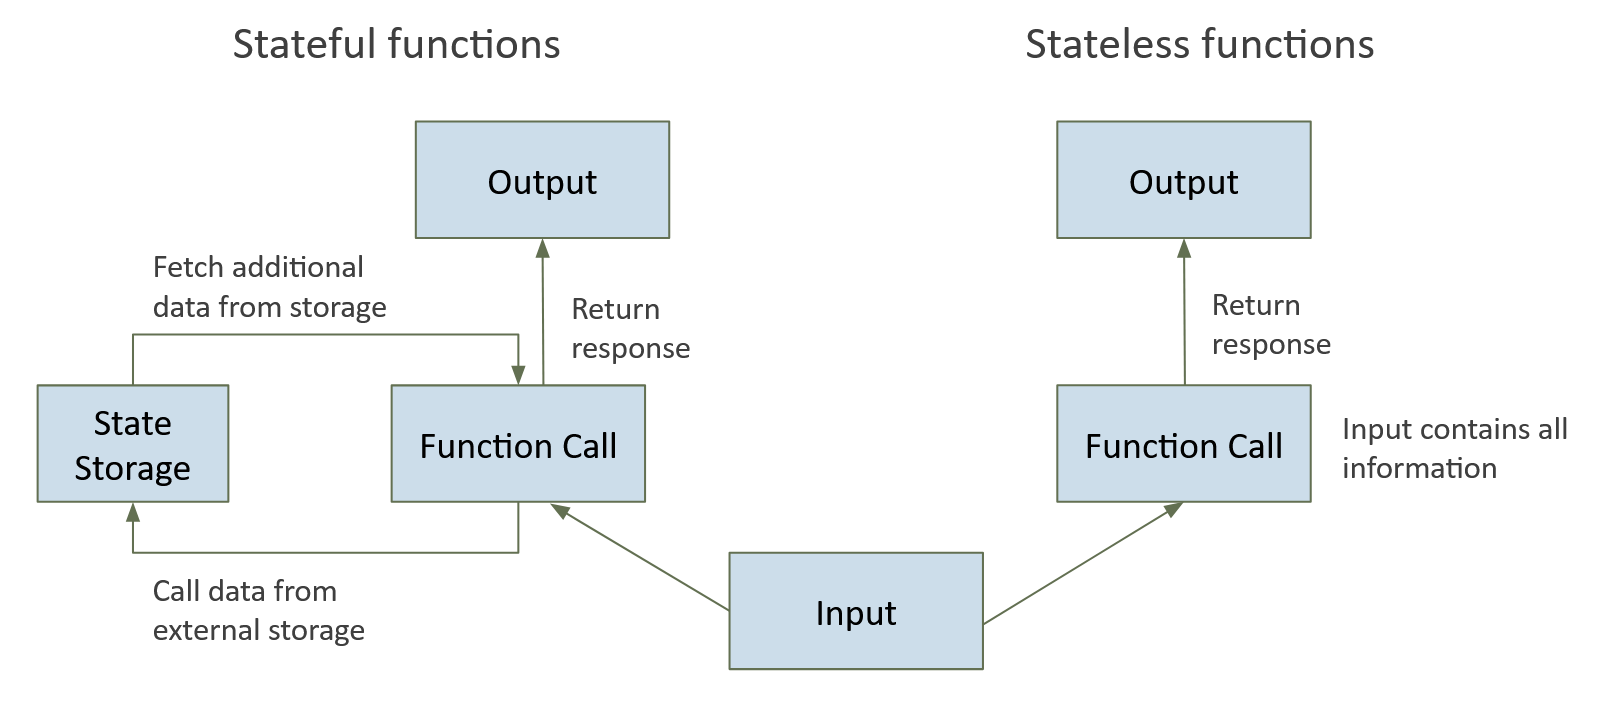

### c) Squelette d'un environnement en Jax


Pour résumer les composants des environnements JAX, voici un code squelette pour un environnement JAX :

```python
class Observation(NamedTuple):
    ...

class MyEnv(Environment[State]):
    def __init__(self):
        ...

    def reset(self, key: chex.PRNGKey) -> Tuple[State, TimeStep[Observation]]:
        observation = Observation(...)
        state = State(key=key, ...)
        timestep = restart(observation)
        return state, timestep

    def step(self, state: State, action: chex.Array) -> Tuple[State, TimeStep[Observation]]:
        next_state = State(key=state.key, ...)
        done = ...
        reward = ...
        next_observation = Observation(...)

        next_timestep = jax.lax.cond(
            done,
            termination,
            transition,
            reward,
            next_observation,
        )

        return next_state, next_timestep

    def observation_spec(self) -> specs.Spec[Observation]:
        obs_spec = ...
        return obs_spec

    def action_spec(self) -> specs.Spec:
        action_spec = ...
        return action_spec
```

> 🔎 Vous pourriez rencontrer des termes et des usages inconnus comme TimeStep, State, etc. Nous les introduirons dans la section 1.3 à travers l'exemple de l'environnement 2048 !

####**Que sont les specs ? 🤔**

**`observation_spec()`** 👁️🔍


```python
def observation_spec(self) -> specs.Spec:
      """Spécifications de l'observation de l'environnement `Game2048`."""
        pass
```


   - **Objectif:** Définit la spécification des observations dans l'environnement.
   - **Details:** Retourne un objet `Spec` de la bibliothèque `jumanji` qui étend le `dm_env.spec.Array`. Cet objet détaille la forme et le type de l'observation, y compris le plateau de jeu et le masque d'action, avec des méthodes comme `self.name`, `self.generate_value`, et `self.validate`.


**`action_spec()`** 🎯


```python
def action_spec(self) -> specs.DiscreteArray:
        """Retourne la spécification de l'action."""
         pass
```


   - **Objectif:** Spécifie l'espace d'action pour l'environnement.
   - Cette matrice représente les actions que l'agent peut entreprendre pour manipuler le plateau de jeu.


## 1.2 Analysons le MDP pour 2048 !


>**Qu'est-ce que le jeu 2048 ? 🎮** 2048 est un jeu de puzzle populaire en solo qui se joue sur une grille de 4x4. Le plateau de jeu est composé de cases, chacune contenant une puissance de 2, et l'objectif est d'atteindre un score d'au moins 2048 en fusionnant les cases ensemble. Le joueur peut déplacer toute la grille dans l'une des quatre directions (haut ⬆️, bas ⬇️, droite ➡️, gauche ⬅️) pour combiner des cases de même valeur. Lorsque deux cases adjacentes ont la même valeur, elles fusionnent en une seule case avec une valeur égale à la somme des deux cases.

Le jeu se termine lorsque le joueur ne peut plus effectuer de mouvements supplémentaires. Le but ultime 🏆 est d'atteindre la case de plus grande valeur possible, en espérant dépasser 2048. À chaque mouvement, le joueur doit planifier et élaborer une stratégie soigneusement pour atteindre le score le plus élevé possible.


<h3><details>
  <summary>🔽 <b>Récapitulatif des Fondamentaux du MDP : Cliquez en Cas d'Oubli </b> 🔽</summary>

Un MDP se compose des éléments suivants :


<font size=8> $\langle \color{orange}{\mathcal{S}}, \color{blue}{\mathcal{A}}, \color{purple}{P}, \color{green}{R}, \color{black}{\gamma}\rangle$  </font>


*  $ \color{orange}{\mathcal{S}}$  (espace des états) - représente toutes les configurations valides de votre environnement, c'est-à-dire à quoi peut ressembler votre environnement.  
*  $\color{blue}{\mathcal{A}}$ (espace d'action)   - représente toutes les actions valides, c'est-à-dire ce que vos agents peuvent faire.  
*  $\color{purple}{P}$ (fonction de transition)   - cela vous indique la probabilité de transition vers un nouvel état, étant donné que vous êtes dans un état spécifique et que vous effectuez une action ->  $s_{t+1}=P(s_t, a_t)$
*  $\color{green}{R}$ (fonction de récompense)  - nous indique à quel point votre paire d'état et d'action actuelle est bonne -> $r_t = R(s_t,a_t)$
*  $\color{black}{\gamma}$ (facteur de discount)   - terme qui contrôle la pondération entre la valeur que nous accordons aux récompenses futures par rapport aux récompenses immédiates.

</details></h3>


### a) États (State) 🏙️


> *L'état est une description complète de l'état du monde (l'environnement).*

Dans le jeu 2048, un état représente la configuration actuelle du plateau de jeu. Le plateau de jeu est une grille 4x4 où chaque case peut être vide ou contenir une tuile avec une valeur qui est une puissance de 2. Chaque arrangement unique de tuiles sur le plateau est un état différent.


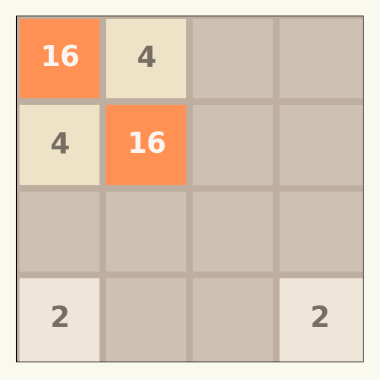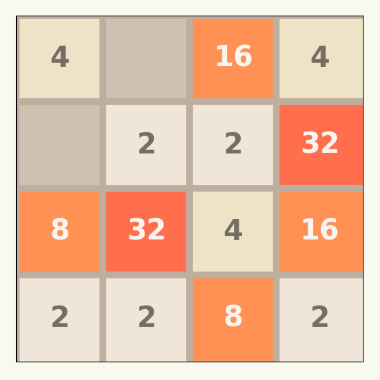

**Représentation du Plateau de Jeu avec des matrices :**


Dans le jeu 2048, le plateau peut être représenté comme une matrice 4x4 (si size_board=4) où chaque case contient soit une puissance de 2 (représentant une tuile), soit 0 (représentant une case vide). Cette représentation sous forme de matrice permet une manipulation et un calcul faciles de l'état du jeu. Par exemple, pour représenter l'état du plateau ci-dessus (celui à gauche), nous avons :

```python
[16,  4,  0,  0]
[ 4, 16,  0,  0]
[ 0,  0,  0,  0]
[ 2,  0,  0,  2]
```





### b) Actions 🎮


>*L'espace d'action est l'ensemble de toutes les actions possibles que les agents peuvent effectuer dans l'environnement.*

Dans le jeu 2048, les **actions** sont les mouvements que vous pouvez effectuer :
  - **Haut ⬆️**
  - **Bas ⬇️**
  - **Gauche ⬅️**
  - **Droite ➡️**

Chaque action fait glisser les tuiles sur le plateau dans la direction correspondante et les fusionne si elles ont la même valeur.

🕹️ Pour effectuer ces mouvements, l'agent choisit un numéro qui correspond à l'une des actions :
0 : Déplacer vers le Haut ⬆️
1 : Déplacer vers la Droite ➡️
2 : Déplacer vers le Bas ⬇️
3 : Déplacer vers la Gauche ⬅️.
La décision de l'agent sur le numéro à choisir détermine la direction dans laquelle les tuiles sur le plateau vont se déplacer.


### c) Probabilités de Transition 🎲


>*Les probabilités de transition nous indiquent la probabilité de passer d'un état à un autre après avoir effectué une action.*

Dans le jeu 2048, cela inclut :
  - Comment les tuiles se déplacent et se fusionnent (ce qui est déterministe).
  - Où la nouvelle tuile (généralement un 2 ou parfois un 4) apparaît après chaque mouvement (ce qui est aléatoire).


### d) Récompenses 🏆


> *Dans un MDP, les récompenses sont des signaux de retour reçus de l'environnement après avoir effectué une action dans un état, indiquant le bénéfice immédiat de cette action.*


#### **Exercice 1 (Travail de groupe)**


Discutez avec vos voisins de ce que devrait être la fonction de récompense dans le jeu 2048 pour encourager l'agent à jouer efficacement.

Prenez un moment pour y réfléchir avant d'ouvrir la solution 🤔


<h5><details>
<summary><b>Cliquez ici pour dévoiler des indices !</b> 🔽</summary>
  
- **Indice 1 :** Réfléchissez à ce qui se passe lorsque vous combinez avec succès des tuiles.
- **Indice 2 :** Pensez à la manière dont le jeu évalue votre progression et votre objectif final.

</details></h5>

<h5><details>
<summary><b>Solution</b> 💡</summary>
  
La **récompense** nous aide à comprendre le bénéfice immédiat d'une action. Pour le jeu 2048, elle peut être définie en fonction des points suivants :
   
* **Combinaison de Tuiles :** Lorsque deux tuiles se combinent, elles forment une nouvelle tuile avec une valeur égale à la somme des deux tuiles originales. Ce processus de combinaison est crucial pour la progression du jeu. Par conséquent, une bonne fonction de récompense devrait donner une récompense positive pour chaque combinaison, reflétant la valeur de la nouvelle tuile. Par exemple, combiner deux tuiles de 2 pour former un 4 pourrait donner une récompense de 4.

* **Progression du Jeu :** L'objectif principal est d'atteindre la tuile 2048, mais d'ici là, plus les tuiles que vous créez sont élevées, mieux c'est. Par conséquent, chaque combinaison devrait récompenser l'agent en fonction de la valeur de la nouvelle tuile créée. La récompense peut être directement proportionnelle à la valeur de la tuile.

  
Par exemple, si un joueur fusionne deux tuiles de valeur 512 pour créer une nouvelle tuile de valeur 1024, puis fusionne deux tuiles de valeur 256 pour créer une nouvelle tuile de valeur 512, la récompense totale de ces actions est de 1536 (c'est-à-dire 1024 + 512).

Cette fonction de récompense encourage l'agent à faire des mouvements qui combinent les tuiles et créent des tuiles de valeur plus élevée, en travaillant finalement pour atteindre l'objectif de créer la tuile 2048.

>⚠️ Remarque : La fonction de récompense n'est pas unique, et il pourrait y avoir d'autres stratégies de récompense qui pourraient fonctionner efficacement.
</details></h5>


## 1.3 Gestion des Entrées dans un Environnement Sans État (Stateless) à Travers l'Exemple de 2048 : Définition des Types


### a) Gestion de l'État du Jeu 2048 🕹️


Pour gérer efficacement l'état de l'environnement dans le jeu 2048, nous devons stocker plusieurs composants clés :

1. **Plateau** 🎲 : Représente l'état actuel du plateau de jeu.
2. **Clé Aléatoire** 🔑 : Utilisée pour toutes les opérations stochastiques, telles que l'échantillonnage de l'emplacement et de la valeur d'une nouvelle tuile.
3. **Masque d'Action** 🎭 : Un tableau binaire indiquant quelles actions sont légales dans l'état actuel.
4. **Compteur de Pas** ⏳ : Suivi du nombre de pas effectués dans l'épisode en cours. Aide à terminer l'épisode lorsque l'horizon prédéfini est atteint.
5. **Score** 🏅 : Accumule la récompense cumulative, montrant les progrès et la performance du joueur dans le jeu.

Pour encapsuler ces informations, nous définissons les classes `State` et `Observation` comme suit :


In [ ]:
Board: TypeAlias = Array #Plateau

class State(NamedTuple):
    board: Board
    step_count: Numeric
    action_mask: Array
    key: PRNGKey
    score: Numeric

class Observation(NamedTuple):
    board: Board
    action_mask: Array

### b) Interaction Agent-Environnement 🌐


- **Timestep ⏱️** : Un point unique dans le temps au sein du jeu où l'agent interagit avec l'environnement. Pensez-y comme à une photo 📸 dans un album, capturant un moment spécifique dans le processus en cours.
- **Étapes de l'Épisode 🔄🛑🔀** : Inclut le redémarrage (état initial), la terminaison (état final) et la transition (passage entre les états).

Pour encapsuler ces concepts, nous définissons la classe `TimeStep` comme suit :

```python
@dataclass
class TimeStep(Generic[Observation]):
    step_type: StepType  # Type de l'étape (redémarrage, transition ou terminaison)
    reward: Array  # Récompense reçue à ce timestep
    discount: Array  # Facteur de discount pour les récompenses futures
    observation: Observation  # Observation faite à ce timestep
    extras: Dict = field(default_factory=dict)  # Toute information supplémentaire

```

# 2. Implémentation des Fonctions Utils pour le jeu 2048


Pour simuler efficacement l'environnement du jeu 2048, nous devons implémenter plusieurs fonctions utilitaires qui gèrent les opérations clés du jeu. Ces fonctions seront essentielles pour gérer l'état du jeu, effectuer des mouvements, fusionner des tuiles et introduire de nouvelles tuiles aléatoires. Décomposons l'implémentation de ces fonctions utilitaires critiques :

1. **Génération d'une Case Aléatoire :** Cette fonction ajoutera une nouvelle tuile sur le plateau, généralement un 2 ou parfois un 4, à une position vide aléatoire.

2. **Génération du Plateau Initial :** Cette fonction initialisera le plateau de jeu au début d'une partie, en plaçant généralement deux tuiles aléatoires sur le plateau.

3. **Fusion des Tuiles :** Cette fonction gérera la fusion des tuiles lorsqu'elles sont déplacées dans la même direction et ont la même valeur.

4. **Mouvement des Tuiles :** Cet ensemble de fonctions gérera le déplacement des tuiles dans les quatre directions possibles (haut, bas, gauche, droite) et gérera la logique globale du mouvement dans le jeu.

L'utilité de ces fonctions peut être illustrée dans la figure suivante où l'agent décide de se déplacer vers la droite ➡


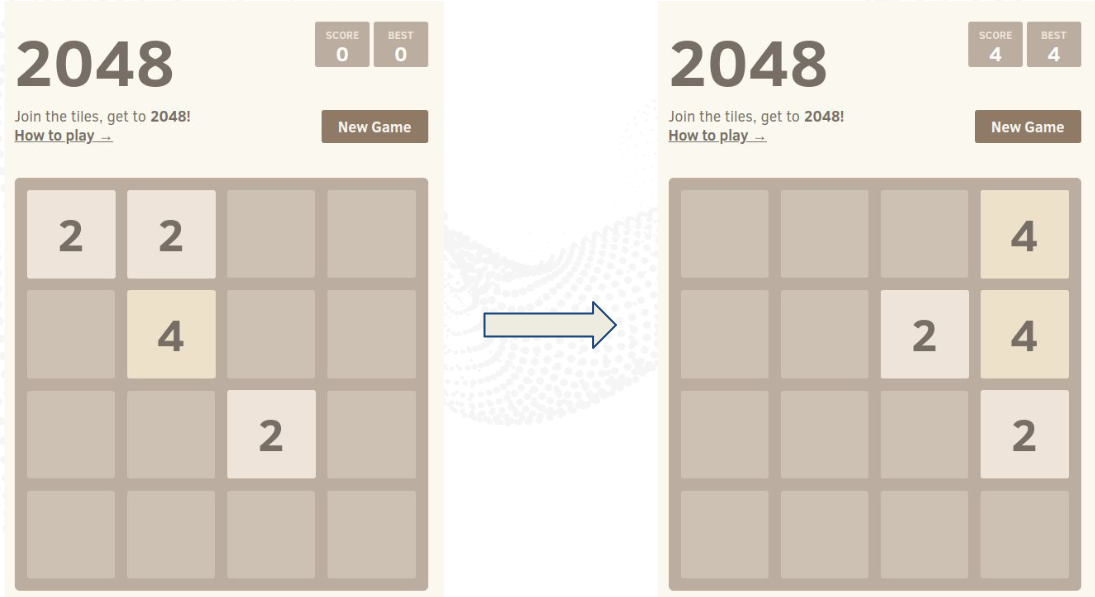

## Case aléatoire


>**Dans l'environnement du jeu 2048, à chaque fois que vous effectuez un mouvement, une nouvelle case apparaît comme par magie dans un emplacement vide de la grille !**


### 🎲 Comment ça Marche ? 🎲


Voici la recette secrète :

  **🔄 À Chaque Étape :** Après chaque interaction avec l'environnement, une nouvelle case apparaît dans l'un des emplacements vides.
  
 **🧮 Détails des Probabilités :**

*   Il y a 90 % de chances (🟢 0,9) que la nouvelle case soit un 2.
* Et 10 % de chances (🔴 0,1) qu'elle soit un 4.


### 🛠️ Plan d'Implémentation Initial 🛠️


Voici le plan simple pour y parvenir :

  **🕵️‍♂️ Trouver les Emplacements Vides :** Obtenir l'index de tous les emplacements vides sur la grille.
  
  **🎯 Choisir un Emplacement au Hasard :** Sélectionner aléatoirement l'un de ces indices.

  **🎲 Choisir la Valeur :** Décider aléatoirement si la nouvelle case sera un 2 ou un 4 en fonction de leurs probabilités.

  **✨ Mettre à Jour la Grille :** Changer la valeur de la grille à l'indice choisi par la nouvelle valeur.


### 🥊Temps d'implemetation : Numpy vs. JAX🥊


>**Avant de plonger dans le code, discutons rapidement des similitudes et des différences entre NumPy et JAX**


#### 🧬 Similarités


* **Opérations sur les Tableaux :** NumPy et JAX offrent tous deux un support pour les opérations et manipulations de tableaux. Vous trouverez des fonctions comme `argwhere`, `choice` et d'autres opérations familières dans les deux bibliothèques.
* **Syntaxe :** La syntaxe pour les opérations de base est assez similaire. Si vous êtes à l'aise avec NumPy, vous trouverez la transition vers JAX relativement fluide.


##### **Exercice 2 Tâche de Code : Implémenter la Fonction Utilitaire pour la Case Aléatoire ! 🎮**

Commençons par implémenter la fonction utilitaire de case aléatoire en nous basant sur notre plan d'implémentation initial. Votre tâche consiste à compléter les parties manquantes de la cellule de code fournie ci-dessous en utilisant NumPy.


<h5><details>
  <summary>🔽 <b>Cliquez ici pour dévoiler des indices !</b> 🔽</summary>

1.   Utilisez `numpy.argwhere` pour trouver les indices de tous les emplacements vides (là où la valeur du plateau est 0).
2.   Utilisez `numpy.random.choice` pour sélectionner aléatoirement l'un de ces indices.
3.   Utilisez `numpy.random.choice` avec le paramètre `p` pour choisir entre 2 ou 4 en fonction des probabilités données (90 % pour 2 et 10 % pour 4).

</details></h5>


In [ ]:
# Première approche
def add_random_cell(board: Board) -> Board:

    # Sélectionner la position de la nouvelle case aléatoire
    zero_indices = ... # Trouver tous les indices vides (valeur 0)
    tile_idx =  ... # Sélectionner aléatoirement l'un de ces indices

    # Choisir la valeur de la nouvelle case : 2 avec une probabilité de 90 % ou 4 avec une probabilité de 10 %
    cell_value = ...

    # Mettre à jour le plateau
    ...

    return board

In [ ]:
# @title 🕹️ Testons votre code !

def test_add_random_cell(add_random_cell_fn):
    try:
        # Plateau d'exemple avant l'ajout d'une case aléatoire
        board = np.array(
            [
                [2,  2,  0,  0],
                [4,  8, 16,  0],
                [16, 0, 32, 0],
                [32, 64, 0, 64]
            ]
        )

        # Ajout d'une case aléatoire au plateau
        new_board = add_random_cell_fn(board.copy())

        # Vérifier si la fonction s'est exécutée sans erreurs
        assert new_board is not None, "La fonction n'a pas retourné un plateau valide. Veuillez vérifier votre implémentation."

        # Vérifier si exactement un zéro a été remplacé par un 2 ou un 4
        num_zeros_before = np.sum(board == 0)
        num_zeros_after = np.sum(new_board == 0)
        num_new_tiles = num_zeros_before - num_zeros_after
        unique_values = np.unique(new_board)

        assert num_new_tiles == 1, "Il semble que votre code nécessite un peu de travail. Il devrait y avoir exactement une nouvelle tuile."
        assert any(tile in unique_values for tile in [2, 4]), "La nouvelle tuile devrait être soit un 2 soit un 4."
        print("Bien joué ! Votre réponse semble correcte.")
    except Exception as e:
        print(f"Une erreur s'est produite : {e}")

# Tester la fonction add_random_cell
test_add_random_cell(add_random_cell)


In [ ]:
# @title Solution
def add_random_cell(board: np.ndarray) -> np.ndarray:
    # Sélectionner la position de la nouvelle case aléatoire
    zero_indices = np.argwhere(board == 0)
    tile_idx = np.random.choice(np.arange(len(zero_indices)))

    # Choisir la valeur de la nouvelle case : 2 avec une probabilité de 90 % ou 4 avec une probabilité de 10 %
    cell_value = np.random.choice([2, 4], p=[0.9, 0.1])

    # Mettre à jour le plateau
    board[tuple(zero_indices[tile_idx])] = cell_value

    return board


#### 🔍 Différences


**Génération de Nombres Aléatoires :**

*  NumPy : La génération de nombres aléatoires est simple en utilisant des fonctions comme numpy.random.choice. Cependant, ces fonctions ne garantissent pas intrinsèquement la reproductibilité, ce qui rend plus difficile l'obtention de résultats cohérents entre les exécutions.

*  JAX : Utilise des <font color='green'>clés PRNG</font> pour une génération de nombres aléatoires contrôlée et reproductible.


In [ ]:
import numpy as np
import jax
import jax.numpy as jnp

# Exemple NumPy sans seed
print("NumPy sans fixation de seed (Défaut) :")
for _ in range(3):
    numpy_random_numbers = np.random.choice([2, 4], size=10, p=[0.9, 0.1])
    print("  Exécution :", numpy_random_numbers)

# Fixation d'une seed dans NumPy pour la reproductibilité
print("\nNumPy avec seed fixée :")
for _ in range(3):
    np.random.seed(0)
    numpy_random_numbers = np.random.choice([2, 4], size=10, p=[0.9, 0.1])
    print("  Exécution :", numpy_random_numbers)

# Exemple JAX nécessite une clé PRNG
print("\nJAX avec clé PRNG :")
for _ in range(3):
    key = jax.random.PRNGKey(2)  # Réinitialisation de la clé pour chaque exécution
    jax_random_numbers = jax.random.choice(key, jnp.array([2, 4]), shape=(10,), p=jnp.array([0.9, 0.1]))
    print("  Exécution :", jax_random_numbers)


**Tableaux Immuables :**

*  NumPy : Les tableaux dans NumPy sont mutables. Vous pouvez directement changer les valeurs d'un tableau.
*  JAX : Les tableaux (tensors) dans JAX sont immuables. Pour mettre à jour un tableau, vous utilisez la méthode `.at[]`, qui permet des mises à jour fonctionnelles sans modifier le tableau original. Cette immutabilité est essentielle pour les fonctionnalités d'optimisation et de différenciation automatique de JAX.


In [ ]:
import numpy as np
import jax
import jax.numpy as jnp

# Exemple NumPy avec tableaux mutables
numpy_array = np.array([1, 2, 3, 4, 5])
print("Tableau NumPy original :", numpy_array)

# Modifier le tableau en place
numpy_array[2] = 99
print("Tableau NumPy modifié :", numpy_array)

# Exemple JAX avec tableaux immuables
jax_array = jnp.array([1, 2, 3, 4, 5])
print("\nTableau JAX original :", jax_array)

# Modifier le tableau en utilisant .at[] pour créer un nouveau tableau
modified_jax_array = jax_array.at[2].set(99)
print("Tableau JAX modifié :", modified_jax_array)

# Le tableau JAX original reste inchangé
print("Tableau JAX original inchangé :", jax_array)


>**Maintenant que nous avons exploré les différences entre NumPy et JAX, en particulier en ce qui concerne la génération de nombres aléatoires et l'immutabilité des tableaux, implémentons notre fonction utilitaire de case aléatoire en utilisant JAX.**


In [ ]:
# Première approche
def add_random_cell(board: Board, key: PRNGKey) -> Board:

    # Générer une nouvelle clé
    key, subkey = jax.random.split(key)

    # Sélectionner la position de la nouvelle case aléatoire
    zero_indices = jnp.argwhere(board == 0)
    tile_idx = jax.random.choice(
        key, jnp.arange(len(zero_indices))
    )

    # Choisir la valeur de la nouvelle case : 2 avec une probabilité de 90 % ou 4 avec une probabilité de 10 %
    cell_value = jax.random.choice(
        subkey, jnp.array([2, 4]), p=jnp.array([0.9, 0.1])
    )
    board = board.at[tuple(zero_indices[tile_idx])].set(cell_value)

    return board


In [ ]:
# Tester add_random_cell
board=jnp.array(
    [
        [ 2,  2,  0,  0],
        [ 4,  8, 16,  0],
        [16,  0, 32,  0],
        [32, 64,  0, 64]
    ]
)
key=jax.random.PRNGKey(0)
board=add_random_cell(board, key)
print(board)


### 🚀 Compilation JIT dans JAX 🚀


**Pourquoi Utiliser JIT ?**
*  Vitesse : Compiler une fonction avec JIT peut la rendre beaucoup plus rapide en optimisant le code et en utilisant l'accélération matérielle (comme les GPU).

*  Efficacité : JIT peut optimiser les opérations répétées, rendant votre code plus efficace.

**Comment Utiliser JIT dans JAX**

Utiliser JIT dans JAX est simple. Il suffit de décorer votre fonction avec `jax.jit` pour activer la compilation JIT.


**Maintenant que nous avons appris la magie de la compilation JIT, mettons-la à l'épreuve ! 🚀 Nous allons appliquer JIT à notre fonction utilitaire de case aléatoire et observer l'amélioration des performances en action. Prêt, partez, JIT ! 🏎️💨**


In [ ]:
# Jitted method
try:
  board=jnp.array(
      [
          [ 2,  2,  0,  0],
          [ 4,  8, 16,  0],
          [16,  0, 32,  0],
          [32, 64,  0, 64]
      ]
  )
  key=jax.random.PRNGKey(0)
  add_random_cell_jit = jax.jit(add_random_cell)
  board = add_random_cell_jit(board, key)
  print(board)
except Exception as e:
  print(f"An error occurred: {e}")

#### 😱 Oh-oh, la Compilation JIT a Échoué !

Il semble que notre tentative de compiler la fonction utilitaire de case aléatoire avec JIT ait rencontré un obstacle 🛑.

**Quel est le problème ?**

Les fonctions JIT ne supportent pas bien les variables non statiques, comme les tableaux, car leur taille n'est pas connue au moment de la compilation. Cela rend difficile pour le compilateur de générer un code efficace pour les gérer.

Voici les détails techniques :

*   Variables non statiques : Leur taille n'est déterminée qu'à l'exécution.
*   Compilateur JIT : Préfère connaître les tailles à l'avance pour des performances optimales.

Cette allocation dynamique est la raison pour laquelle notre fonction jittée n'a pas pu gérer efficacement la variable, en particulier notre utilisation de `jnp.argwhere` qui cause le problème parce qu'elle produit un tableau dont la taille varie en fonction du nombre de cases vides sur le plateau. Mais ne vous inquiétez pas, il y a toujours une solution !


##### **Exercice 3 : Trouver une Solution Alternative ! 🧩**
Notre plan initial utilisant `jnp.argwhere` ne fonctionnera pas avec la compilation JIT. Votre tâche consiste à trouver un autre moyen d'identifier les cases vides sur le plateau (avec un tableau statique) et de réimplémenter la fonction add_random_cell qui peut être jittée. Complétez les parties manquantes de la cellule de code fournie ci-dessous.


<h5><details>
  <summary>🔽 <b>Indice 1 : Idée pour Résoudre le Problème des Tableaux Non Statique</b> 🔽</summary>
Aplatissez la matrice du plateau. Il sera plus facile de manipuler un tableau 1D qu'un tableau 2D lorsqu'il s'agit de choisir une position aléatoire. Étant donné que nous ne pouvons pas utiliser argwhere, changez les valeurs de la matrice en booléens (True si la case est vide, et False sinon) et utilisez random.choice, mais ajoutez des probabilités associées à chaque case.

Après avoir obtenu la position aléatoire de la nouvelle case dans le tableau 1D, traduisez-la en une position 2D sur le plateau.

</details></h5>
<h5><details>
  <summary>🔽 <b>Indice 2 : Aplatir le Tableau</b> 🔽</summary>
Utilisez `jnp.ravel` pour aplatir la matrice du plateau en un tableau 1D.

</details></h5>
<h5><details>
  <summary>🔽 <b>Indice 3 : Trouver les Cases Vides</b> 🔽</summary>
Utilisez `jnp.ravel(board == 0)` pour trouver les cases vides, puis utilisez `random.choice` avec `p` pour vous concentrer uniquement sur les cases vides.

</details></h5>


In [ ]:
def add_random_cell(board: Board, key: PRNGKey) -> Board:
    # Générer une nouvelle clé
    key, subkey = jax.random.split(key)

    # Sélectionner la position de la nouvelle case aléatoire
    # Comment c'était avant :
    #  zero_indices = np.argwhere(board == 0)
    #  tile_idx = np.random.choice(np.arange(len(zero_indices)))
    ...

    # Choisir la valeur de la nouvelle case : 2 avec une probabilité de 90 % ou 4 avec une probabilité de 10 %
    cell_value = jax.random.choice(
        subkey, jnp.array([2, 4]), p=jnp.array([0.9, 0.1])
    )
    board = board.at[position].set(cell_value)

    return board


In [ ]:
# @title 🕹️ Testons votre code !

def test_add_random_cell(add_random_cell_fn):
    try:
        # Plateau d'exemple avant l'ajout d'une case aléatoire
        board = jnp.array(
            [
                [2,  2,  0,  0],
                [4,  8, 16,  0],
                [16, 0, 32, 0],
                [32, 64, 0, 64]
            ]
        )
        # Clé aléatoire pour les opérations stochastiques
        key = jax.random.PRNGKey(0)

        # Méthode jittée pour ajouter une case aléatoire
        add_random_cell_jit = jax.jit(add_random_cell_fn)

        # Ajouter une case aléatoire au plateau
        new_board = add_random_cell_jit(board, key)

        # Vérifier si la fonction s'est exécutée sans erreurs
        assert new_board is not None, "La fonction n'a pas retourné un plateau valide. Veuillez vérifier votre implémentation."

        # Vérifier si exactement un zéro a été remplacé par un 2 ou un 4
        num_zeros_before = jnp.sum(board == 0)
        num_zeros_after = jnp.sum(new_board == 0)
        num_new_tiles = num_zeros_before - num_zeros_after
        unique_values = jnp.unique(new_board)

        assert num_new_tiles == 1, "Il semble que votre code nécessite un peu de travail. Il devrait y avoir exactement une nouvelle tuile."
        assert any(tile in unique_values for tile in [2, 4]), "La nouvelle tuile devrait être soit un 2 soit un 4."
        print("Bien joué ! Votre réponse semble correcte.")
    except Exception as e:
        print(f"Une erreur s'est produite : {e}")

# Tester la fonction add_random_cell
test_add_random_cell(add_random_cell)


In [ ]:
# @title Solution
def add_random_cell(board: Board, key: PRNGKey) -> Board:
    # Générer une nouvelle clé
    key, subkey = jax.random.split(key)

    # Sélectionner la position de la nouvelle case aléatoire
    empty_flatten_board = jnp.ravel(board == 0)
    tile_idx = jax.random.choice(
        key, jnp.arange(len(empty_flatten_board)), p=empty_flatten_board
    )
    # Convertir l'emplacement de la tuile sélectionnée dans le tableau aplati à sa position sur le plateau.
    board_size=board.shape[0]
    position = jnp.divmod(tile_idx, board_size)

    # Choisir la valeur de la nouvelle case : 2 avec une probabilité de 90 % ou 4 avec une probabilité de 10 %
    cell_value = jax.random.choice(
        subkey, jnp.array([2, 4]), p=jnp.array([0.9, 0.1])
    )
    board = board.at[position].set(cell_value)

    return board

# Méthode jittée
board=jnp.array(
    [
        [ 2,  2,  0,  0],
        [ 4,  8, 16,  0],
        [16,  0, 32,  0],
        [32, 64,  0, 64]
    ]
)
key=jax.random.PRNGKey(0)
add_random_cell_jit = jax.jit(add_random_cell)
board = add_random_cell_jit(board, key)
print(board)


## 2.2 Générer le Plateau Initial


>**Créons le point de départ de notre jeu 2048 ! Cette fonction générera un plateau de jeu initial pour notre environnement. Le plateau commencera vide, puis nous remplirons une case aléatoire avec une valeur de 2 ou 4.**


### 🛠️ Plan d'Implémentation 🛠️


**1.   Créer un Plateau Vide :** Générer un plateau rempli de zéros, avec une taille spécifiée `board_size`.

**2.   Remplir une Case Aléatoire :** Utiliser notre fonction add_random_cell pour placer un 2 ou un 4 dans une case aléatoire.


### 💻 Temps d'Implementation 💻


In [ ]:
def generate_board(board_size: int, key: PRNGKey) -> Board:
    # Créer un plateau vide
    board = jnp.zeros((board_size, board_size), dtype=jnp.int32)

    # Remplir une case aléatoire avec une valeur de 2 ou 4
    board = add_random_cell(board, key)

    return board


**🧪 Testons-le ! 🧪**

Maintenant, testons notre fonction generate_board pour la voir en action. Nous allons générer un plateau 4x4 et remplir une case aléatoire :


In [ ]:
# Tester generate_board
board_size = 4
key = jax.random.PRNGKey(0)
initial_board = generate_board(board_size, key)
print(initial_board)


## 2.3 Mouvements du Plateau et Stratégies de Fusion des Éléments


### **a) Déplacer vers le Haut une Colonne**

>**Pour déplacer tous les éléments non nuls d'une colonne vers le haut tout en maintenant leur ordre et en remplissant les positions restantes avec des zéros, nous pouvons suivre une approche simple.**


Voyons comment cela fonctionne avec un exemple :

**Tableau d'Origine :**
```python
[[0],
 [2],
 [0],
 [2]]
```

**Colonne Déplacée :**
```python
[[2],
 [2],
 [0],
 [0]]

```

#### 🛠️ Plan d'Implémentation 🛠️


**1.  Déplacer les Éléments Non Nuls :**

*  *`i` (Index de l'Itérateur) :* Parcourt chaque élément de la colonne.

*  *`j` (Index de la Prochaine Position Libre) :* Suit la prochaine position pour un élément non nul.

-> *Processus :* Lorsque `i` inspecte chaque élément, si celui-ci n'est pas nul, il est déplacé à la position `j`. `j` est ensuite incrémenté.

**2.  Remplir les Positions Restantes avec des Zéros :**

*Processus :* Après que tous les éléments non nuls sont positionnés, commencez à partir de `j` et remplissez toutes les positions suivantes avec des zéros jusqu'à la fin de la colonne.


<h5><details>
  <summary>🔽 <b>Cliquez Ici pour un Exemple Concis Étape par Étape</b> 🔽</summary>

Tableau Initial : `[0, 2, 0, 2]`

**Aperçu du Processus :**

*  `i` (Index de l'Itérateur) : Parcourt chaque élément de la colonne.

*  `j` (Index de la Prochaine Position Libre) : Suit la prochaine position pour un élément non nul.

**Étapes :**

*  À l'index 1 : L'élément est 2. Il est déplacé à la position `j` (commence à 0), et `j` est incrémenté.

*  À l'index 3 : Un autre 2 est rencontré et déplacé à la prochaine position disponible `j` (maintenant 1), et `j` est de nouveau incrémenté.

-> Cela donne `[2, 2, 0, 2]` et `j` égal à 2.

**Post-Déplacement :**

*  Remplir avec des Zéros : Les positions à partir de `j` (commençant à l'index 2) sont définies à zéro.
Tableau Résultant : `[2, 2, 0, 0]`

</details></h5>


### 💻 Temps d'Implementation 💻


In [ ]:
def shift_up(col: Array) -> Array:
    # Initialiser un pointeur pour suivre la prochaine position où insérer un élément non nul
    j = 0

    # Parcourir le tableau et placer tous les éléments non nuls à gauche
    for i in range(len(col)):
        if col[i] != 0:
            col = col.at[j].set(col[i])  # Placer l'élément non nul à la prochaine position libre
            j += 1  # Préparer la prochaine position

    # Remplir les positions restantes avec des zéros
    while j < len(col):
        col = col.at[j].set(0)
        j += 1

    return col


**🧪 Testons-le ! 🧪**

Testons notre fonction `shift_up` avec une colonne d'exemple :


In [ ]:
# Tester shift_up
board_col = jnp.array([0, 2, 0, 2])
updated_col = shift_up(board_col)
print(updated_col)

#### 🚀 Défi de Compilation JIT 🚀


Lorsque nous essayons de compiler cette fonction avec JIT, nous pourrions rencontrer des problèmes car les fonctions JIT ne peuvent pas gérer certains types d'opérations dynamiques comme les structures de données de taille variable ou les instructions de contrôle de flux (instructions if et boucles while).

**Pourquoi ?**

Les fonctions JIT nécessitent de connaître les tailles à l'avance pour des performances optimales, ce qui est délicat avec les allocations dynamiques.


In [ ]:
# Tester la compilation JIT de shift_up
try:
  board_col = jnp.array([0, 2, 0, 2])
  shift_up_jit = jax.jit(shift_up)
  updated_col = shift_up_jit(board_col)
  print(updated_col)
except Exception as e:
  print(f"An error occurred: {e}")


#### 🛠️ Solution Utilisant jax.lax 🛠️
Nous pouvons utiliser le module jax.lax, qui fournit des opérations de bas niveau pour construire des calculs numériques à haute performance.

*  Instruction `if` : `jax.lax.cond(condition, true_fn, false_fn, vars)`

* Boucle `while` : `jax.lax.while_loop(cond_fn, body_fn, init_val)`

* Boucle `for` : `jax.lax.scan(f, init, xs)`

Modifions notre fonction pour utiliser jax.lax afin d'assurer la compatibilité avec JIT !


**i) `jax.lax.cond`**


`jax.lax.cond` nous permet d'exécuter l'une des deux branches de code en fonction d'une condition, similaire à une instruction if-else, mais conçue pour être compatible avec JIT.


Code original :
```python
if col[i] != 0:
  col = col.at[j].set(col[i])
  j += 1
```
Code converti :




In [ ]:
def shift_nonzero_element(carry: Tuple) -> Tuple[Array, int]:
    """Définition de la fonction True"""
    # Déballer le tuple pour obtenir la colonne, l'index d'insertion actuel et l'index de l'élément à vérifier
    col, j, i = carry

    # Définir la valeur à l'index d'insertion actuel sur la valeur de l'élément à l'index i
    col = col.at[j].set(col[i])

    # Incrémenter l'index d'insertion pour le prochain élément potentiellement non nul
    j += 1

    return col, j

def shift_column_elements_up(carry: Tuple, i: int) -> Tuple[Array, None]:
    # Déballer le tuple pour obtenir la colonne actuelle et l'index d'insertion
    col, j = carry

    # Déplacer conditionnellement l'élément non nul à l'index i vers l'index d'insertion
    # Si l'élément à l'index i est zéro, passez simplement l'état actuel
    col, j = jax.lax.cond(
        col[i] != 0, # condition
        shift_nonzero_element, # true_fn
        lambda col_j_i: col_j_i[:2], # false_fn
        (col, j, i) # vars
    )

    return (col, j), None


**ii) `jax.lax.scan`**

`jax.lax.scan` est utilisé pour itérer sur une séquence, similaire à une boucle for, mais il renvoie l'état final et tous les états intermédiaires, ce qui le rend adapté aux opérations comme le déplacement des éléments dans un tableau.


Code original :
```python
for i in range(len(col)):
    if col[i] != 0:
        col = col.at[j].set(col[i])
        j += 1
```
Code converti:


In [ ]:
def shift_up(col: Array) -> Array:
    # Initialiser l'index d'insertion à zéro
    j = 0

    # Parcourir la colonne, en déplaçant les éléments non nuls vers le haut
    # `shift_column_elements_up` est appliqué à chaque index d'élément dans la colonne
    (col, j), _ = jax.lax.scan(
        f=shift_column_elements_up, # fn: le premier input est les vars init et le second input est une tranche de xs, qui est dans notre cas `i`.
        init=(col, j), # vars init
        xs=jnp.arange(len(col)) # xs: liste sur laquelle boucler ses éléments
    )

    # Remplir les positions restantes avec des zéros
    #while j < len(col):
    #    col = col.at[j].set(0)
    #    j += 1
    return col


📌 Où la sortie est un tuple : le premier élément `(col, j)` représente la valeur finale de la boucle, et le second élément `_` représente les sorties empilées du second output de la fonction `shift_column_elements_up`.


**iii) `jax.lax.while_loop`**

`jax.lax.while_loop` est utilisé pour exécuter une boucle avec une condition, similaire à une boucle while.


Code original :
```python
while j < len(col):
    col = col.at[j].set(0)
    j += 1
```
Code converti:

In [ ]:
def fill_with_zero(carry: Tuple[Array, int]) -> Tuple[Array, int]:
    """Définir body_fn de la boucle while"""
    # Déballer le tuple pour obtenir la colonne actuelle et l'index d'insertion
    col, j = carry

    # Définir la position actuelle j dans la colonne à zéro
    col = col.at[j].set(0)

    # Incrémenter l'index d'insertion pour passer à la position suivante
    j += 1

    return col, j

def shift_up(col: Array) -> Array:
    # Initialiser l'index d'insertion à zéro
    j = 0

    # Parcourir la colonne, en déplaçant les éléments non nuls vers le haut
    (col, j), _ = jax.lax.scan(
        f=shift_column_elements_up,
        init=(col, j),
        xs=jnp.arange(len(col))
    )

    # Après que tous les éléments non nuls ont été déplacés vers le haut, remplir les positions restantes avec des zéros
    # Cette boucle while continue jusqu'à ce que toutes les positions de j à la fin de la colonne soient mises à zéro
    col, j = jax.lax.while_loop(
        lambda col_j: col_j[1] < len(col_j[0]), # fonction conditionnelle
        fill_with_zero, # body_fn (true_fn)
        (col, j) #init_vars
    )

    return col


🏎️ Testons la Compilation JIT ! 🏎️

Testons notre nouvelle version de la fonction `shift_up` avec une colonne d'exemple :


In [ ]:
board_col = jnp.array([0, 2, 0, 2])
shift_up_jit = jax.jit(shift_up)
updated_col = shift_up_jit(board_col)
print(updated_col)

### **b) Fusion des Éléments**


>**Dans l'environnement du jeu 2048, vous pouvez combiner des éléments adjacents égaux d'une colonne. Par exemple, `[0, 0, 2, 2]` peut être fusionné pour produire `[0, 0, 4, 0]`.**


#### 🎲 Comment ça Marche ? 🎲


Voici le plan étape par étape :

*  **🕵️‍♂️ Vérifier les Éléments Adjacent Égaux :** Parcourir la colonne pour vérifier les éléments adjacents qui sont égaux et non nuls.

* **🎯 Fusionner les Éléments :** Lorsque deux éléments adjacents sont égaux :
  * Les fusionner en doublant la valeur du premier élément et en mettant le second élément à zéro.
  * Ajouter la valeur de l'élément fusionné à la récompense.


#### 💻 Temps d'Implementation 💻


**Étape 1 : Fusion des Éléments**

Tout d'abord, nous définissons une fonction `merge_elements` pour gérer la fusion de deux éléments adjacents égaux. Cette fonction doublera la valeur du premier élément et mettra le second élément à zéro tout en mettant à jour la récompense.


In [ ]:
def merge_elements(carry: Tuple[jnp.ndarray, float, int]) -> Tuple[jnp.ndarray, float]:
    col, reward, i = carry  # Déballer le tuple d'entrée en la colonne, la récompense actuelle et l'index
    new_col_i = 2 * col[i]  # Doubler la valeur de l'élément à l'index i
    col = col.at[i].set(new_col_i)  # Définir la valeur doublée à l'index i
    col = col.at[i + 1].set(0)  # Mettre la valeur à l'index i + 1 à zéro
    reward += new_col_i  # Ajouter la valeur de l'élément fusionné à la récompense
    return col, reward

**Étape 2 : Vérification des Éléments Adjacent Égaux**

Ensuite, nous définissons une fonction `merge_equal_elements` qui utilise `jax.lax.cond` pour vérifier si l'élément actuel et l'élément suivant sont égaux et non nuls. S'ils le sont, elle appelle merge_elements.


*Exercice 4* :

Complétez la fonction ci-dessous en remplissant `jax.lax.cond` (consultez [cette sous-section](https://colab.research.google.com/drive/1kK-uFvYGpD3rjvYSpykXbGd3Exsmh9R_?authuser=5#scrollTo=M0f466j9UfSG) pour rafraîchir votre mémoire !)


In [ ]:
def merge_equal_elements(carry: Tuple[jnp.ndarray, float], i: int) -> Tuple[Tuple[jnp.ndarray, float], None]:
    col, reward = carry
    col, reward = jax.lax.cond(
        ... # (condition, true_fn, false_fn, vars)
    )
    return (col, reward), None

In [ ]:
# @title 🕹️ Testons votre code !

def test_merge_equal_elements(user_merge_equal_elements_fn):
    import jax
    import jax.numpy as jnp
    from typing import Tuple

    # Fonction pour fusionner les éléments
    def merge_elements(col_reward_i):
        col, reward, i = col_reward_i
        col = col.at[i].set(col[i] * 2)
        col = col.at[i + 1].set(0)
        reward += col[i]
        return col, reward

    try:
        # Cas de Test 1 : Les éléments sont égaux et non nuls
        col = jnp.array([2, 2, 0, 0])
        reward = 0.0
        (new_col, new_reward), _ = user_merge_equal_elements_fn((col, reward), 0)
        assert jnp.array_equal(new_col, jnp.array([4, 0, 0, 0])), f"Attendu [4, 0, 0, 0] mais obtenu {new_col}"
        assert new_reward == 4.0, f"Récompense attendue 4.0 mais obtenue {new_reward}"

        # Cas de Test 2 : Les éléments ne sont pas égaux
        col = jnp.array([2, 4, 0, 0])
        reward = 0.0
        (new_col, new_reward), _ = user_merge_equal_elements_fn((col, reward), 0)
        assert jnp.array_equal(new_col, jnp.array([2, 4, 0, 0])), f"Attendu [2, 4, 0, 0] mais obtenu {new_col}"
        assert new_reward == 0.0, f"Récompense attendue 0.0 mais obtenue {new_reward}"

        # Cas de Test 3 : Le premier élément est zéro
        col = jnp.array([0, 2, 2, 0])
        reward = 0.0
        (new_col, new_reward), _ = user_merge_equal_elements_fn((col, reward), 1)
        assert jnp.array_equal(new_col, jnp.array([0, 4, 0, 0])), f"Attendu [0, 4, 0, 0] mais obtenu {new_col}"
        assert new_reward == 4.0, f"Récompense attendue 4.0 mais obtenue {new_reward}"

        print("Bien joué ! Votre réponse semble correcte.")
    except Exception as e:
        print(f"Une erreur s'est produite : {e}")

# Tester la fonction merge_equal_elements
test_merge_equal_elements(merge_equal_elements)


In [ ]:
# @title Solution
def merge_equal_elements(carry: Tuple[jnp.ndarray, float], i: int) -> Tuple[Tuple[jnp.ndarray, float], None]:
    col, reward = carry
    col, reward = jax.lax.cond(
        (col[i] != 0) & (col[i] == col[i + 1]),  # Condition : les éléments aux index i et i+1 sont égaux et non nuls
        merge_elements,  # Fonction à appeler si la condition est vraie
        lambda col_reward_i: col_reward_i[:2],  # Fonction à appeler si la condition est fausse (passe sans changement)
        (col, reward, i),
    )
    return (col, reward), None


**Étape 3 : Itération à Travers la Colonne**

Enfin, nous utilisons `jax.lax.scan` pour parcourir la colonne et appliquer `merge_equal_elements` à chaque paire d'éléments adjacents.


In [ ]:
@jax.jit
def merge_col(col: jnp.ndarray) -> Tuple[jnp.ndarray, float]:
    reward = 0.0
    elements_indices = jnp.arange(len(col) - 1)
    (col, reward), _ = jax.lax.scan(
        f=merge_equal_elements, init=(col, reward), xs=elements_indices
    )
    return col, reward

**🧪 Testons-le ! 🧪**


In [ ]:
print("Colonne initiale : ", board_col)

shift_up_jit = jax.jit(shift_up)
updated_col = shift_up_jit(board_col)
print("Après déplacement des éléments : ", updated_col)

updated_col = merge_col(updated_col)

print("Après fusion des éléments égaux : ", updated_col[0], "avec une récompense égale à : ", updated_col[1])

### **c) Différents Mouvements**


>**Nous devons implémenter les mouvements pour le jeu 2048 : haut, bas, gauche et droite.**


#### 🎲 Comment ça Marche ? 🎲


*  **🕵️‍♂️ Déplacement des Éléments vers le Haut :** Utiliser la fonction `shift_up` pour déplacer tous les éléments non nuls vers le haut de la colonne.
* **🎯 Fusion des Éléments :** Utiliser la fonction `merge_col` pour fusionner les éléments adjacents égaux.
* **🔄 Déplacement des Éléments vers le Haut à Nouveau :** Utiliser la fonction `shift_up` à nouveau pour déplacer les éléments après la fusion.


#### 💻 Temps d'Implementation 💻


**Étape 1 : Déplacer une Colonne vers le Haut**

Nous allons définir une fonction `move_up_col` pour gérer le déplacement d'une seule colonne. Cette fonction déplacera les éléments vers le haut, les fusionnera, puis les déplacera à nouveau vers le haut.


In [ ]:
def move_up_col(carry: Tuple[jnp.ndarray, float], c: int) -> Tuple[Tuple[jnp.ndarray, float], None]:
    board, additional_reward = carry
    col = board[:, c]
    col = shift_up(col)  # Dans l'exemple : [4, 4, 2, 2] -> [4, 4, 2, 2]
    col, reward = merge_col(col)  # Dans l'exemple : [4, 4, 2, 2] -> [8, 0, 4, 0]
    col = shift_up(col)  # Dans l'exemple : [8, 0, 4, 0] -> [8, 4, 0, 0]
    additional_reward += reward
    return (board.at[:, c].set(col), additional_reward), None

**Étape 2 : Déplacer toutes les Cellules du Plateau vers le Haut**

Nous allons définir une fonction `move_up` pour gérer le déplacement de toutes les colonnes du plateau. Cette fonction utilisera `jax.lax.scan` pour appliquer `move_up_col` à chaque colonne.


In [ ]:
@jax.jit
def move_up(board: Board) -> Tuple[Board, float]:
    """Déplacer vers le haut."""
    additional_reward = 0.0  # Initialiser la récompense à zéro
    col_indices = jnp.arange(board.shape[0])  # Plateau de taille 4 -> [0, 1, 2, 3]
    (board, additional_reward), _ = jax.lax.scan(
        f=move_up_col,
        init=(board, additional_reward),
        xs=col_indices,
    )
    return board, additional_reward

**Étape 3 : Déplacer vers le Bas, la Gauche et la Droite**

Nous allons définir des fonctions pour déplacer vers le bas, la gauche et la droite. Ces fonctions utiliseront la fonction `move_up` en tournant ou en retournant le plateau de manière appropriée.



In [ ]:
def move_down(board: jnp.ndarray) -> Tuple[jnp.ndarray, float]:
    """Déplacer vers le bas."""
    board, additional_reward = move_up(
        board=jnp.flip(board, 0)
    )
    return jnp.flip(board, 0), additional_reward

def move_left(board: jnp.ndarray) -> Tuple[jnp.ndarray, float]:
    """Déplacer vers la gauche."""
    board, additional_reward = move_up(
        board=jnp.rot90(board, k=-1)
    )
    return jnp.rot90(board, k=1), additional_reward

def move_right(board: jnp.ndarray) -> Tuple[jnp.ndarray, float]:
    """Déplacer vers la droite."""
    board, additional_reward = move_up(
        board=jnp.rot90(board, k=1)
    )
    return jnp.rot90(board, k=-1), additional_reward

**🔥 Maintenant, essayons de faire un mouvement vers le haut sur le plateau 🔥**


In [ ]:
board = jnp.array([
    [4, 2, 2, 0],
    [4, 8, 2, 4],
    [4, 8, 2, 4],
    [4, 8, 0, 0]
  ])
board, reward = move_up(board)
print("Après déplacement vers le haut : \n", board, "\n Récompense : ", reward)

# 3. Implémentation de l'Environnement


>**Découvrons maintenant la classe `Game2048` de l'environnement du jeu 2048, avec ses méthodes variées et cool pour initialiser facilement le plateau de jeu, ajouter de nouvelles tuiles et gérer les mouvements de l'agent.**


## 3.1 Fonctions Principales dans `Game2048`


### **a) Comprendre la Méthode `reset` ♻️**


Réinitialiser un environnement, c'est comme appuyer sur le bouton de réinitialisation de votre console de jeu 🎮. L'environnement démarre avec un nouvel état frais, assurant que tout est en place et prêt pour un nouveau tour d'interaction 🏋.


env_reset.drawio.svg

Pipeline étape par étape pour la fonction `reset` :
1. **Initialiser le Plateau 🏁 :** Configure un nouveau plateau avec une tuile aléatoire pour démarrer le jeu.
2. **Générer le Masque d'Action 🎭 :** Crée un tableau binaire qui indique quelles actions sont valides et lesquelles ne le sont pas.
3. **Retourner l'État Initial et l'Observation 🎬 :** Fournit l'état de départ pour l'agent, y compris la configuration initiale du plateau et les actions valides.



In [ ]:
def reset(key: PRNGKey) -> Tuple[State, TimeStep[Observation]]:
    """Réinitialise l'environnement."""

    # Diviser la clé pour créer de l'aléatoire pour l'initialisation du plateau.
    key, board_key = jax.random.split(key)

    # Générer le plateau initial avec une tuile aléatoire.
    board = self._generate_board(board_key)

    # Obtenir le masque d'action indiquant les actions valides.
    action_mask = self._get_action_mask(board)

    # Créer l'observation initiale.
    obs = Observation(board=board, action_mask=action_mask)

    # Créer un objet TimeStep marquant le début d'un nouvel épisode.
    timestep = restart(observation=obs)

    # Créer l'état initial de l'environnement.
    state = State(
        board=board,
        step_count=jnp.int32(0),
        action_mask=action_mask,
        key=key,
        score=jnp.array(0, float),
    )
    return state, timestep

### **b) Méthode `_get_action_mask` 🎭**


**Exercice 5 : Définir le Masque d'Action pour les Mouvements Valides**

Dans cet exercice, vous implémenterez la méthode `_get_action_mask`. Cette méthode génère un masque binaire indiquant quelles actions sont valides en fonction de l'état actuel du plateau de jeu. Une action est considérée comme valide si elle entraîne un changement dans l'état du plateau.

</details></h5>
<h5><details>
  <summary>🔽 <b>Indice 1 </b> 🔽</summary>
Vérifiez si l'une des actions (déplacement vers le haut, vers la droite, vers le bas, vers la gauche) modifie l'état du plateau.

</details></h5>
<h5><details>
  <summary>🔽 <b>Indice 2 </b> 🔽</summary>
Utilisez `jnp.any` pour vérifier si une action entraîne un état de plateau différent.


In [ ]:
def _get_action_mask(board: Board) -> Array:
    """Génère un masque binaire indiquant quelles actions sont valides."""
    action_mask = ... # Deviner la logique pour déterminer les actions valides en fonction de l'état actuel.
    return action_mask

In [ ]:
# @title 🕹️ Testons votre code !

def test_get_action_mask(get_action_mask_fn):
    try:
        # États de plateau échantillon
        board1 = jnp.array(
            [
                [2, 2, 0, 0],
                [4, 8, 16, 0],
                [16, 0, 32, 0],
                [32, 64, 0, 64]
            ]
        )
        board2 = jnp.array(
            [
                [4, 2, 4, 2],
                [4, 2, 4, 2],
                [4, 2, 4, 2],
                [4, 2, 4, 2]
            ]
        )
        expected_mask1 = jnp.array([True, True, True, True])
        expected_mask2 = jnp.array([True, False, True, False])

        # Tester la fonction avec des plateaux échantillon
        mask1 = get_action_mask_fn(board1)
        mask2 = get_action_mask_fn(board2)

        assert jnp.array_equal(mask1, expected_mask1), f"Test échoué pour board1 : attendu {expected_mask1}, obtenu {mask1}"
        assert jnp.array_equal(mask2, expected_mask2), f"Test échoué pour board2 : attendu {expected_mask2}, obtenu {mask2}"

        print("Bien joué ! Votre réponse semble correcte.")
    except Exception as e:
        print(f"Une erreur s'est produite : {e}")

# Tester la fonction _get_action_mask
test_get_action_mask(lambda board: _get_action_mask(board))

In [ ]:
# @title Solution

def _get_action_mask(board: Board) -> Array:
    """Génère un masque binaire indiquant quelles actions sont valides."""
    action_mask = jnp.array(
        [
            jnp.any(move_up(board)[0] != board),
            jnp.any(move_right(board)[0] != board),
            jnp.any(move_down(board)[0] != board),
            jnp.any(move_left(board)[0] != board),
        ],
    )
    return action_mask

### **c) Comprendre la Méthode `step` ➡️**


La méthode **`step`** met à jour l'état de l'environnement en fonction de l'action de l'agent. Elle est généralement appelée à chaque étape d'un épisode. Cette fonction gère les mécanismes principaux du jeu ⭐, y compris :

1. **Appliquer l'Action de l'Agent** ▶️ : La fonction traite l'action (Haut, Droite, Bas, Gauche) choisie par l'agent, en mettant à jour le plateau en conséquence.
2. **Mettre à jour le Masque d'Action 🎭 :** Indique quelles actions sont valides après le déplacement.
3. **Vérification de la Fin du Jeu** 🛑 : La fonction vérifie si le jeu est terminé, soit en atteignant la tuile 2048, soit en n'ayant plus de mouvements valides.
4. **Ajouter une Nouvelle Tuile Aléatoire 🆕 :** Place une nouvelle tuile sur le plateau, sauf si le jeu est terminé.
5. **Retourner le Nouvel État et l'Observation 👀 :** Fournit l'état mis à jour et le feedback (récompense) à l'agent. Les récompenses 🏅 sont attribuées pour les bons coups, en particulier lorsque les tuiles sont fusionnées avec succès, ce qui correspond généralement à la somme des valeurs des tuiles fusionnées.

Dans l'exemple ci-dessous, deux tuiles avec le même nombre (2) se touchent lors d'un déplacement et fusionnent en une seule tuile avec une valeur égale à la somme des deux tuiles (2+2=4 -> récompense=4).


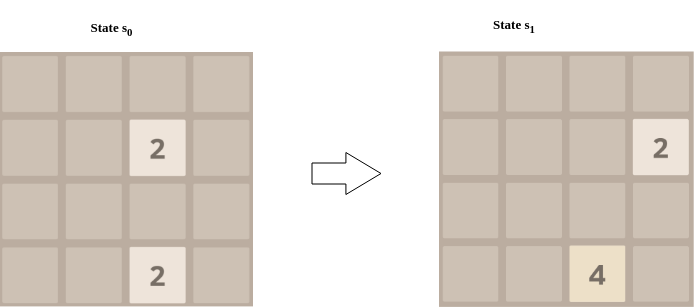

**Exercice 5 : Définir la Fonction `step`**


Remplissez les parties manquantes de la fonction step pour implémenter les mécanismes principaux du jeu.


</details></h5>
<h5><details>
  <summary>🔽 <b>Indice 1 : Déterminer si le jeu est terminé</b> 🔽</summary>
Vérifiez si les agents ne peuvent plus effectuer de mouvements, alors le jeu se termine : Utilisez `jnp.any` pour vérifier s'il n'y a pas d'actions légales (`action_mask`).
</details></h5>

<h5><details>
  <summary>🔽 <b>Indice 2 : Mettre à jour le plateau</b> 🔽</summary>
Vérifiez si le jeu n'est pas terminé, puis ajoutez une nouvelle case aléatoire au plateau, sinon gardez le plateau inchangé car l'épisode se terminera et il n'y a plus de place pour ajouter une case.
</details></h5>

<h5><details>
  <summary>🔽 <b>Indice 3 : Mettre à jour l'état de l'environnement</b> 🔽</summary>
Créez un nouvel objet état reflétant le plateau mis à jour, le masque d'action, le compteur d'étapes incrémenté, la clé aléatoire mise à jour et le score cumulatif avec la récompense supplémentaire.
</details></h5>


In [ ]:
def step(state: State, action) -> Tuple[State, TimeStep[Observation]]:
    """Met à jour l'état de l'environnement après que l'agent a pris une action."""

    # Appliquer l'action pour mettre à jour le plateau : lax.switch applique exactement une des branches données par l'index.
    updated_board, additional_reward = jax.lax.switch(
        action,  # L'action choisie par l'agent (0 : Haut, 1 : Droite, 2 : Bas, 3 : Gauche)
        [move_up, move_right, move_down, move_left],  # Liste des fonctions à appeler en fonction de l'action
        state.board,  # L'état actuel du plateau
    )

    # Générer le nouveau masque d'action.
    action_mask = self._get_action_mask(updated_board)

    # Vérifier si le jeu est terminé.
    done = ... # TODO : Deviner la logique

    # Diviser la clé pour créer de l'aléatoire pour l'ajout d'une nouvelle tuile.
    random_cell_key, new_state_key = jax.random.split(state.key)

    # Mettre à jour l'état du plateau en ajoutant une nouvelle tuile aléatoire sauf si le jeu est terminé.
    updated_board = jax.lax.cond(  # TODO : Deviner la logique -- voir section 3.2
        done,
        ..., # True_fn : Si terminé (l'épisode est terminé)
        ..., # False_fn : Si l'épisode est toujours en cours
        updated_board, # var_1
        random_cell_key, # var_2
    )

    # Mettre à jour l'état de l'environnement.
    state = State(  # TODO : Deviner la logique
        board=...,
        action_mask=...,
        step_count=...,
        key=...,
        score=..., # Rappel : le score est cumulatif (ancien_score + récompense) !
    )

    # Créer la nouvelle observation.
    observation = Observation(board=updated_board, action_mask=action_mask)

    # Créer l'objet TimeStep.
    timestep = jax.lax.cond(
        done,
        termination,
        transition,
        additional_reward,
        observation,
    )

    return state, timestep

In [ ]:
# @title Solution
def step(state: State, action) -> Tuple[State, TimeStep[Observation]]:
    """Met à jour l'état de l'environnement après que l'agent a pris une action."""

    # Appliquer l'action pour mettre à jour le plateau : lax.switch applique exactement une des branches données par l'index.
    updated_board, additional_reward = jax.lax.switch(
        action,  # L'action choisie par l'agent (0 : Haut, 1 : Droite, 2 : Bas, 3 : Gauche)
        [move_up, move_right, move_down, move_left],  # Liste des fonctions à appeler en fonction de l'action
        state.board,  # L'état actuel du plateau
    )

    # Générer le masque d'action.
    action_mask = _get_action_mask(board=updated_board)

    # Vérifier si l'épisode se termine (c'est-à-dire s'il n'y a plus d'actions légales).
    done = ~jnp.any(action_mask)

    # Générer une nouvelle clé.
    random_cell_key, new_state_key = jax.random.split(state.key)

    # Mettre à jour l'état du plateau en ajoutant une nouvelle case aléatoire sauf si le jeu est terminé.
    updated_board = jax.lax.cond(
        done,
        lambda board, pkey: board,
        _add_random_cell,
        updated_board,
        random_cell_key,
    )
    # Construire l'état.
    state = State(
        board=updated_board,
        action_mask=action_mask,
        step_count=state.step_count + 1,
        key=new_state_key,
        score=state.score + additional_reward.astype(float),
    )
    # Générer l'observation à partir de l'état de l'environnement.
    observation = Observation(board=updated_board, action_mask=action_mask)

    # Retourner soit un MID soit un LAST timestep selon si l'épisode est terminé.
    timestep = jax.lax.cond(
        done,
        termination,
        transition,
        additional_reward,
        observation,
    )
    return state, timestep


### **Implémentation Complète de `Game2048`** 🎉


🎉 Enfin, la grande révélation de notre jeu ! 🎉

Dans cette partie, vous verrez la magie de toutes les méthodes et pièces que nous avons introduites se rassembler en parfaite harmonie. Pensez-y comme au grand final d'un feu d'artifice, où tout s'assemble et éblouit ! Préparez-vous à voir comment toutes les parties en mouvement fonctionnent ensemble pour créer l'expérience ultime du jeu 2048 ! 🚀✨

In [ ]:
class Game2048(Environment[State, specs.DiscreteArray, Observation]):

    def __init__(self, board_size: int = 4, env_viewer: Optional[Game2048Viewer] = None) -> None:
        """Initialise l'environnement du jeu avec une taille de plateau spécifiée et un visualiseur optionnel pour le rendu."""
        self.board_size = board_size
        # Créer un visualiseur utilisé pour le rendu
        self._env_viewer = env_viewer or Game2048Viewer("2048", board_size)

    def __repr__(self) -> str:
        """Représentation sous forme de chaîne de caractères de l'environnement."""
        return f"Jeu 2048 (board_size={self.board_size})"

    def reset(self, key: PRNGKey) -> Tuple[State, TimeStep[Observation]]:
        """Réinitialise l'environnement."""

        key, board_key = jax.random.split(key)
        board = self._generate_board(board_key)
        action_mask = self._get_action_mask(board)

        obs = Observation(board=board, action_mask=action_mask)
        timestep = restart(observation=obs)

        state = State(
            board=board,
            step_count=jnp.int32(0),
            action_mask=action_mask,
            key=key,
            score=jnp.array(0, float),
        )
        return state, timestep

    def step(self, state: State, action) -> Tuple[State, TimeStep[Observation]]:
        """Met à jour l'état de l'environnement après que l'agent a pris une action."""

        # Effectuer l'action dans l'environnement : Haut, Droite, Bas, Gauche.
        updated_board, additional_reward = jax.lax.switch(
            action,
            [move_up, move_right, move_down, move_left],
            state.board,
        )

        # Générer un masque d'action pour le garder dans l'état pour la prochaine étape et
        # le fournir à l'agent dans l'observation.
        action_mask = self._get_action_mask(board=updated_board)

        # Vérifier si l'épisode se termine (c'est-à-dire s'il n'y a plus d'actions légales).
        done = ~jnp.any(action_mask)

        # Générer une nouvelle clé.
        random_cell_key, new_state_key = jax.random.split(state.key)

        # Mettre à jour l'état du plateau en ajoutant une nouvelle tuile aléatoire.
        updated_board = jax.lax.cond(
            done,
            lambda board, pkey: board,
            self._add_random_cell,
            updated_board,
            random_cell_key,
        )
        # Construire l'état.
        state = State(
            board=updated_board,
            action_mask=action_mask,
            step_count=state.step_count + 1,
            key=new_state_key,
            score=state.score + additional_reward.astype(float),
        )
        # Générer l'observation à partir de l'état de l'environnement.
        observation = Observation(board=updated_board, action_mask=action_mask)

        # Retourner soit un MID soit un LAST timestep selon si l'épisode est terminé.
        timestep = jax.lax.cond(
            done,
            termination,
            transition,
            additional_reward,
            observation,
        )
        return state, timestep

    def _generate_board(self, key: PRNGKey) -> Board:
        """Génère un plateau initial pour l'environnement."""

        # Créer un plateau vide
        board = jnp.zeros((self.board_size, self.board_size), dtype=jnp.int32)

        # Remplir une case aléatoire avec une valeur de 2 ou 4
        board = self._add_random_cell(board, key)

        return board

    def _add_random_cell(self, board: Board, key: PRNGKey) -> Board:
        """Ajoute une nouvelle tuile aléatoire au plateau."""
        key, subkey = jax.random.split(key)

        # Sélectionner la position de la nouvelle tuile aléatoire
        empty_flatten_board = jnp.ravel(board == 0)
        tile_idx = jax.random.choice(
            key, jnp.arange(len(empty_flatten_board)), p=empty_flatten_board
        )
        # Convertir l'emplacement de la tuile sélectionnée dans le tableau aplati à sa position sur le plateau.
        position = jnp.divmod(tile_idx, self.board_size)

        # Choisir la valeur de la nouvelle tuile : 2 avec une probabilité de 90 % ou 4 avec une probabilité de 10 %
        cell_value = jax.random.choice(
            subkey, jnp.array([2, 4]), p=jnp.array([0.9, 0.1])
        )
        board = board.at[position].set(cell_value)

        return board

    def _get_action_mask(self, board: Board) -> Array:
        """Génère un masque binaire indiquant quelles actions sont valides. """
        action_mask = jnp.array(
            [
                jnp.any(move_up(board)[0] != board),
                jnp.any(move_right(board)[0] != board),
                jnp.any(move_down(board)[0] != board),
                jnp.any(move_left(board)[0] != board),
            ],
        )
        return action_mask

    def observation_spec(self) -> specs.Spec:
      """Spécifications de l'observation de l'environnement `Game2048`."""
      return specs.Spec(
          Observation,
          "ObservationSpec",
          board=specs.Array(
              shape=(self.board_size, self.board_size),
              dtype=jnp.int32,
              name="board",
          ),
          action_mask=specs.BoundedArray(
              shape=(4,),
              dtype=bool,
              minimum=False,
              maximum=True,
              name="action_mask",
          ),
      )

    def action_spec(self) -> specs.DiscreteArray:
        """Retourne la spécification d'action."""
        return specs.DiscreteArray(4, name="action")

    def render(self, state: State, save: bool = True, path: str = "./2048.png") -> None:
        """Rend l'état actuel du plateau de jeu."""
        self._env_viewer.render(state=state, save=save, path=path)

    def animate(
        self,
        states: Sequence[State],
        interval: int = 200,
        save_path: Optional[str] = None,
    ):
        """Crée un gif animé du plateau de jeu 2048 basé sur la séquence d'états de jeu."""
        return self._env_viewer.animate(
            states=states, interval=interval, save_path=save_path
        )


# 4. Agent Advantage Actor-Critic & Rendu


## 4.1 Advantage Actor-Critic (A2C)

A2C est un algorithme de type Actor-Critic en apprentissage par renforcement (RL) qui permet à un agent de s'améliorer au fil du temps sur une tâche donnée. Nous n'entrerons pas ici dans les détails de l'algorithme, mais si vous êtes intéressé par l'apprentissage de celui-ci, vous pouvez consulter le [cours d'introduction au RL de HuggingFace](https://huggingface.co/learn/deep-rl-course/en/unit6/advantage-actor-critic).



## 4.2 Regardons un agent A2C jouer à 2048

Nous avons déjà entraîné un agent à jouer à 2048. Voyons comment notre agent se débrouille !


<IPython.core.display.Javascript object>

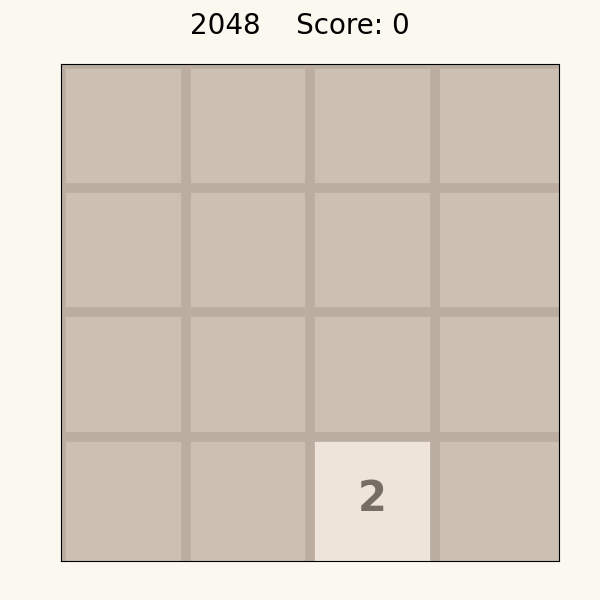

In [ ]:
rollout_and_render_policy(env_name="game_2048", agent_name="a2c")

Nous avons déjà entraîné un agent à jouer à 2048. Voyons comment notre agent se débrouille !

Notez que notre agent n'est pas encore parfait, mais il a commencé à apprendre une stratégie commune à 2048 où il déplace la tuile de plus grande valeur vers le coin tout en essayant d'augmenter sa valeur ! Nous pouvons également noter que cet agent entraîné fait bien mieux que notre score manuel de 1120 obtenu plus tôt dans le notebook.

Si vous êtes prêt à relever un défi, vous pouvez essayer d'utiliser [Jumanji](https://github.com/instadeepai/jumanji) pour entraîner votre propre agent A2C. Notez que cela est complètement facultatif et doit être vu comme un défi après cette pratique pour ceux qui sont intéressés.


## 4.3 (Optionnel) Entraîner un agent A2C sur 2048 en utilisant Jumanji


Pour entraîner un agent A2C, vous pouvez suivre ces étapes :
1. Dans un répertoire sur votre ordinateur, clonez le repo Jumanji en exécutant

```bash
git clone https://github.com/instadeepai/jumanji.git
```
2. Dans un environnement virtuel, installez les dépendances d'entraînement de Jumanji

```bash
pip install -e ".[train]"
```

3.Si vous avez accès à un GPU, suivez les [instructions sur le dépôt JAX](https://github.com/google/jax?tab=readme-ov-file#instructions) pour installer JAX pour votre GPU.

4. Modifiez le fichier de configuration d'entraînement trouvé dans `jumanji/training/configs/config.yaml` pour qu'il ressemble à ceci:

```yaml
defaults:
    - _self_
    - env: game_2048  # [bin_pack, cleaner, connector, cvrp, flat_pack, game_2048, graph_coloring, job_shop, knapsack, maze, minesweeper, mmst, multi_cvrp, pac_man, robot_warehouse, rubiks_cube, sliding_tile_puzzle, snake, sokoban, sudoku, tetris, tsp]

agent: a2c  # [random, a2c]

seed: 0

logger:
    type: terminal  # [neptune, tensorboard, terminal]
    save_checkpoint: false  # [false, true]
    name: ${agent}_${env.name}
```

5. Lancez une session d'entraînement en exécutant :

```bash
python jumanji/training/train.py
```


# 5. (Optionnel) Au-delà du Processus de Décision de Markov (MDP)



**Processus de Décision de Markov Partiellement Observable (POMDPs)**

Les MDPs standards supposent que tout l'espace d'observation est visible pour l'agent. Bien que cela convienne à l'environnement de 2048 que nous allons coder aujourd'hui, cette hypothèse ne peut pas être faite dans des environnements plus complexes ou pour des agents qui doivent agir dans le monde réel.

Dans l'exemple ci-dessous, nous voyons ce problème avec le routage des trains. À gauche, un état entièrement observable permet à l'agent de prendre en compte tous les facteurs de l'environnement à chaque étape de planification. Sur les images de droite, nous limitons l'observation de l'agent à une petite zone autour de lui. Cela complique la prise de décision, car l'agent doit maintenant agir avec des informations incomplètes. Cette observabilité partielle invalide également une des hypothèses du MDP standard, car plusieurs observations d'agent peuvent sembler identiques tout en étant différentes dans l'espace d'état complet.

Par exemple, si la voiture jaune était bloquée sur la voie en dehors de notre champ de vision et que nous pouvions voir tout l'espace d'état, nous pourrions facilement la prendre en compte et mettre à jour notre navigation en toute sécurité pour éviter une collision. Cependant, avec une vision limitée, nous devrions déduire la position de la voiture à partir d'observations précédentes.


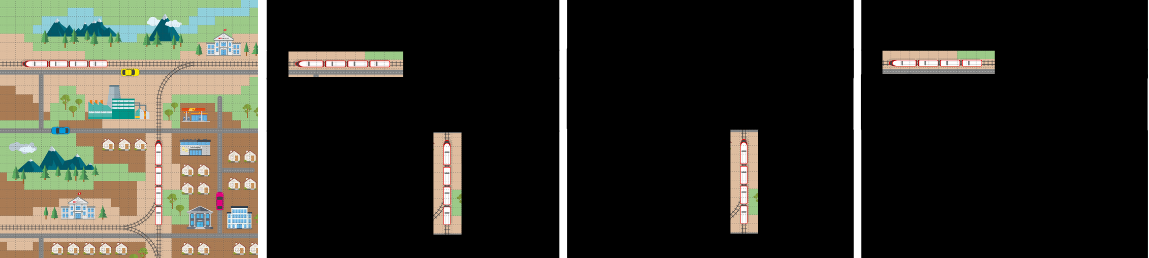

Pour résoudre ce problème, le POMDP ajoute une fonction supplémentaire apprenable à la formule MDP appelée **O**.

\[
POMDP = \langle S,U,r,p,\Omega,O,\gamma \rangle
\]

O est une distribution de probabilité sur les observations pour chaque paire état-action et est utilisée pour mapper les observations centrées sur l'agent à une approximation de l'état réel.

En pratique, c'est un problème très difficile à résoudre, mais dans de nombreux cas, il est suffisant d'apprendre O comme une fonction conditionnée par l'historique des observations de l'agent, en utilisant quelque chose comme un RNN. Pour illustrer cela, nous allons utiliser un cadre plus simple que le routage des trains, avec le jeu Breakout.

Comme exercice simple, regardez l'image ci-dessous et essayez de prédire où la balle se déplace et dans quelle direction vous devez vous déplacer.


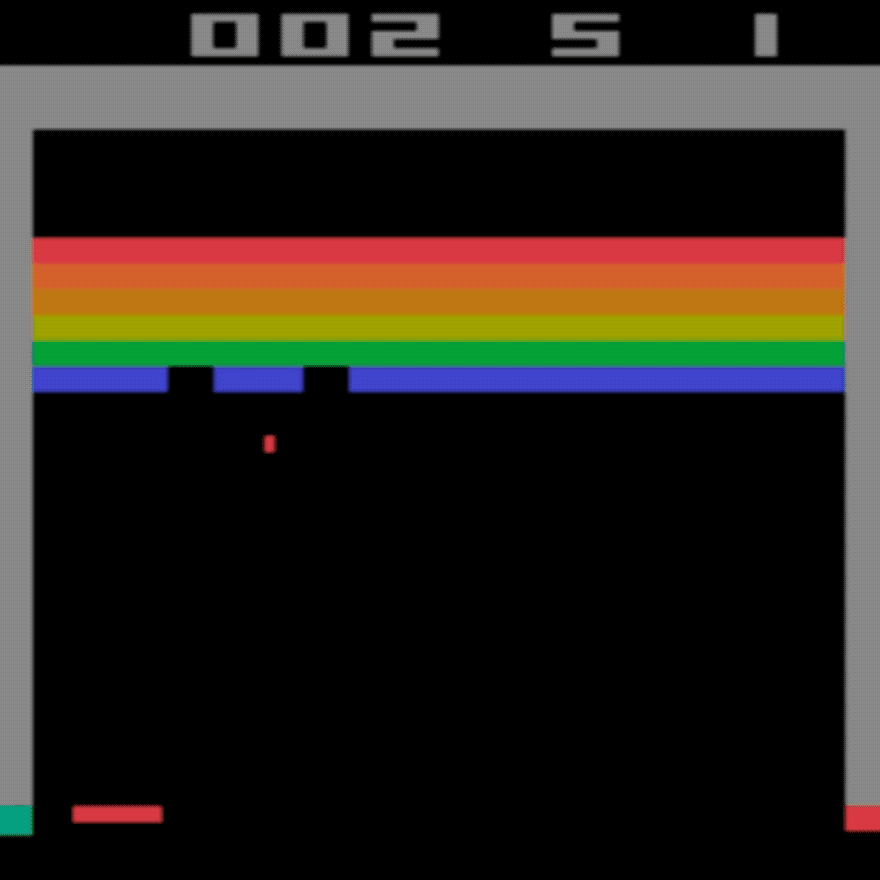

<h5><details>
  <summary>🔽 <b>Réponse ici</b> 🔽</summary>

La balle se déplace vers la gauche, comme nous pouvons le voir sur l'image suivante.


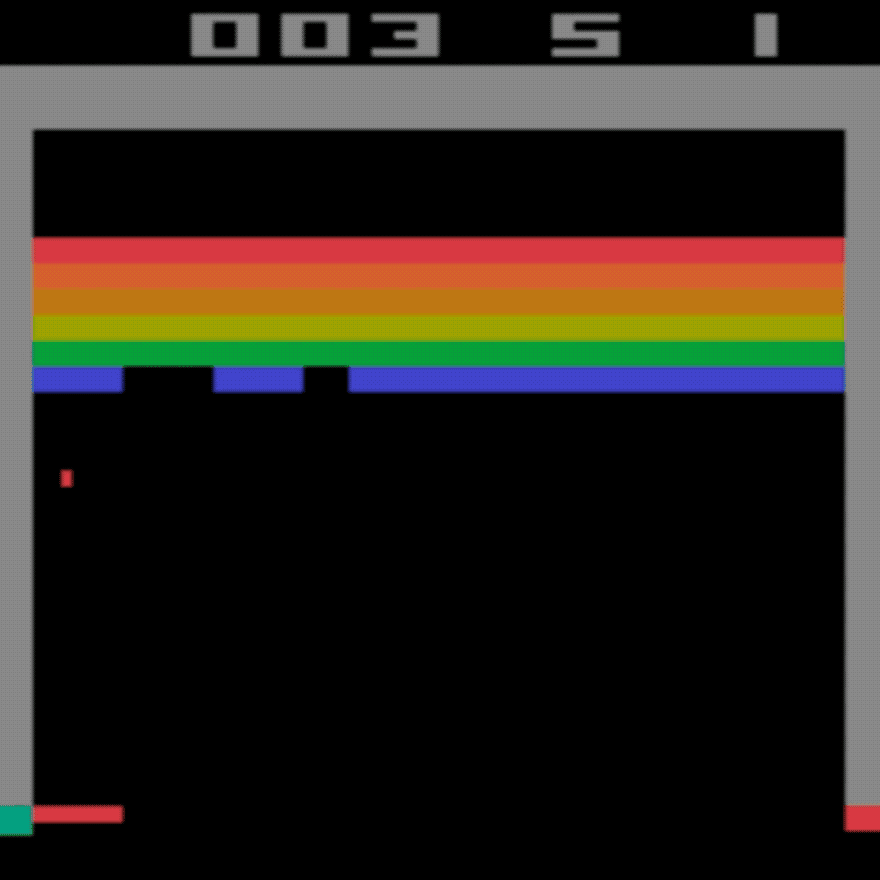

Quand nous disons que les états dans un POMDP peuvent se ressembler, c'est ce que nous entendons. Sans information supplémentaire, nous ne pouvons pas toujours déterminer l'action optimale pour un état partiellement observable. Maintenant, regardez l'image ci-dessous qui contient plusieurs images prises à différents moments.


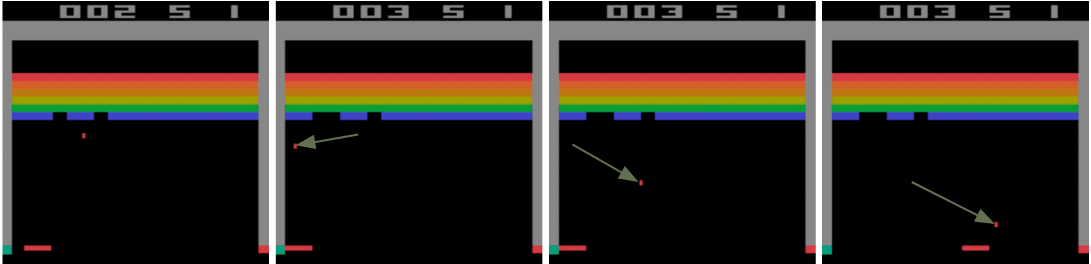

À partir des observations sur plusieurs instants, nous pouvons facilement déterminer la direction de la balle. C'est le composant de la fonction O, qui est la probabilité d'une observation donnée un état-action, mentionnée plus haut. Dans ce jeu, il est possible d'apprendre O en utilisant, par exemple, un réseau neuronal récurrent pour apprendre une représentation des observations conditionnée par des paires état-action passées.


# Conclusion
**Résumé :**

Dans ce cours pratique, nous avons abordé les fondamentaux de l'apprentissage par renforcement (RL) en utilisant le jeu 2048 comme environnement. Nous avons exploré les éléments clés du RL, notamment les états, actions, récompenses et transitions, et vu comment ces éléments forment un Processus de Décision de Markov (MDP). Grâce à des exercices pratiques, nous avons appris à implémenter l'environnement de 2048 en utilisant JAX, depuis la génération du plateau de jeu initial jusqu'à la gestion de l'état et des interactions du jeu. Nous avons également vu comment concevoir des fonctions utilitaires telles que le déplacement des colonnes, la fusion des éléments et l'ajout de cellules aléatoires au plateau.

En implémentant et testant ces fonctions, nous avons acquis une meilleure compréhension de la modélisation et de la simulation d'un environnement RL. De plus, nous avons démontré la boucle d'interaction entre un agent RL et l'environnement, en mettant en évidence le processus de mise à jour des états et d'accumulation de récompenses. Enfin, nous avons visualisé les performances de l'agent à travers des animations pour observer la progression de l'agent dans le jeu.

**Prochaines étapes :**

Après avoir maîtrisé l'environnement, l'étape suivante consiste à en apprendre davantage sur l'agent :

- Le manuel de référence sur le RL - [Apprentissage par renforcement : Une Introduction](http://incompleteideas.net/book/the-book-2nd.html).
- DLI RL Prac 2023 : [Frozen Lake : Une aventure glacée avec l'apprentissage par renforcement !](https://github.com/deep-learning-indaba/indaba-pracs-2023/blob/main/practicals/RL_2023_prac.ipynb)

**Références :**

* [DLI RL Prac 2023 : Frozen Lake : Une aventure glacée avec l'apprentissage par renforcement !](https://github.com/deep-learning-indaba/indaba-pracs-2023/blob/main/practicals/RL_2023_prac.ipynb)
* [Jumanji : Une suite d'environnements divers et scalables pour le RL en JAX](https://github.com/instadeepai/jumanji)
  * [Game_2048](https://github.com/instadeepai/jumanji/tree/main/jumanji/environments/logic/game_2048)
* [IndabaX TN 2023 : Construire un environnement 2048 avec Jax !](https://github.com/instadeepai/IndabaX-TN-2023-RL)

Pour d'autres pratiques de Deep Learning Indaba, veuillez visiter [ici](https://github.com/deep-learning-indaba/indaba-pracs-2024).


# Feedback
Merci de fournir un retour d'expérience que nous pourrons utiliser pour améliorer nos pratiques à l'avenir.


In [ ]:
# @title Générer un formulaire de feedback. (Exécutez la cellule)
from IPython.display import HTML

HTML(
    """
<iframe
	src="https://forms.gle/WUpRupqfhFtbLXtN6",
  width="80%"
	height="1200px" >
	Loading...
</iframe>
"""
)

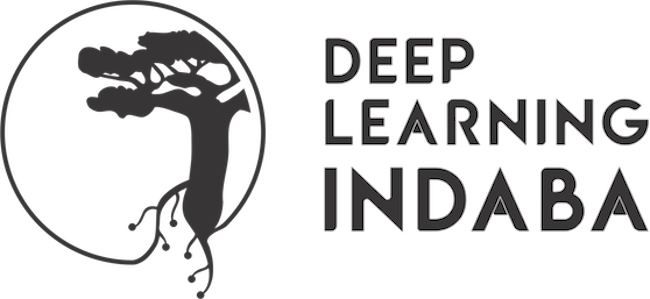